# Wine Price Time Series Analysis

In this notebook, I'm going to analyze wine prices using domestic wine production, exports, imports, average wine prices, and population datasets.

## Contents

1. Setup
    - Import Libraries
    - Set Plot Style
    - Import Data
        - Create Synthetic Variables
    - Train Test Split
2. Granger Causality Tests
3. Stationarity Transformations
4. Modeling
    - Lag Order Selection
    - Fit the Model
    - Serial Correlation of Residuals
    - Forecasting
    - Accuracy
5. Conclusion

## Setup

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import datetime as dt
import calendar
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.stats.stattools import durbin_watson

### Set Plot Style

In [2]:
# Making plots a bit more accessible
style.use('fivethirtyeight')
sns.set_palette('colorblind')

### Import Data

In [3]:
df = pd.read_excel('../data/master-data.xlsx')
df.head()

Unnamed: 0      month  population  price  price_adj      di          bulk  \
0           0 2000-01-31   281083000  5.458   5.299029  9309.1  1.131505e+08   
1           1 2000-02-29   281299000  5.256   5.198813  9345.2  7.179357e+07   
2           2 2000-03-31   281531000  5.471   5.311650  9370.3  4.635628e+07   
3           3 2000-04-30   281763000  5.156   5.104950  9418.3  3.296724e+07   
4           4 2000-05-31   281996000  5.530   5.426889  9457.3  3.178035e+07   

        bottled         cider  effervescent  ...  \
0  1.244070e+08           NaN  6.909175e+06  ...   
1  1.375283e+08           NaN  4.377026e+06  ...   
2  1.603837e+08           NaN  9.321474e+06  ...   
3  1.423004e+08  2.045088e+06  7.881046e+06  ...   
4  1.612658e+08  6.959646e+06  6.334834e+06  ...   

   landed_duty_paid_value_ukfrspde_imports  \
0                                 59812261   
1                                 77087577   
2                                 87219165   
3                                 87040067   
4                                 79534639   

   landed_duty_paid_value_adj_ukfrspde_imports  \
0                                 5.807016e+07   
1                                 7.624884e+07   
2                                 8.467880e+07   
3                                 8.617828e+07   
4                                 7.805166e+07   

   customs_value_ukfrspde_imports  customs_value_adj_ukfrspde_imports  \
0                        56706027                        5.505440e+07   
1                        73873201                        7.306944e+07   
2                        83500840                        8.106878e+07   
3                        83075769                        8.225324e+07   
4                        75599523                        7.418991e+07   

   quantity_ukfrspde_imports  charges_insurance_freight_ukfrspde_imports  \
0                    8768676                                     2406931   
1                    8961916                                     2356486   
2                   10474993                                     2804317   
3                   11128077                                     2989501   
4                   10874051                                     3037785   

   charges_insurance_freight_adj_ukfrspde_imports  \
0                                    2.336826e+06   
1                                    2.330847e+06   
2                                    2.722638e+06   
3                                    2.959902e+06   
4                                    2.981143e+06   

   calculated_duties_ukfrspde_imports  calculated_duties_adj_ukfrspde_imports  \
0                              699303                           678934.951456   
1                              857890                           848555.885262   
2                              914008                           887386.407767   
3                              974797                           965145.544554   
4                              897331                           880599.607458   

   frspger_25  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 83 columns]

I also want to include the top 3 countries' imports data that aren't in the countries affected by the tariffs. I imagine these will be Italy, Chile, and Australia. But I'm not entirely sure. I'll just take the average of the first unit of quantity over the time period for each country in order to select which countries to include. I'm also going to weight the most recent observations twice as high as the oldest observations when calculating the average.

In [4]:
imports_by_country_df = pd.read_excel('../data/imports-to-us-panel.xlsx')

In [5]:
country = []
average_imports = []
for c in imports_by_country_df['Country'].unique():
    if c != 'World':
        c_df = imports_by_country_df.loc[imports_by_country_df['Country'] == c].copy()
        c_df.sort_values(by='month')
        c_df['weight'] = 1 + np.arange(len(c_df)) / len(c_df)
        monthly_avg_q = np.average(c_df['First Unit of Quantity'], weights=c_df['weight'])
        country.append(c)
        average_imports.append(monthly_avg_q)

average_imports_by_country_df =  pd.DataFrame({'country': country, 'avg_imp_q': average_imports})
display(average_imports_by_country_df.nlargest(7, 'avg_imp_q'))

country     avg_imp_q
6       Italy  2.238664e+07
1   Australia  1.375422e+07
4      France  1.034120e+07
3       Chile  8.863492e+06
0   Argentina  5.621417e+06
10      Spain  4.552465e+06
2      Canada  4.051553e+06

It looks like Italy, Australia, and Chile are the biggest exporters to the U.S. that aren't affected by these tariffs.

These datapoints aren't adjusted for inflation. So I'll need to adjust them for inflation in the same way that the other datapoints are adjusted, using the PPI.

In [6]:
ppi_df = pd.read_excel('../data/PCU3121303121300.xls', header=10)

In [7]:
def last_day_of_month(month):
    if pd.isnull(month):
        return
    d = month.split('-')
    date = dt.date(pd.to_numeric(d[0]), pd.to_numeric(d[1]), 1)
    return date.replace(day = calendar.monthrange(date.year, date.month)[1])

In [8]:
ppi_df['month'] = ppi_df['observation_date'].map(lambda x: last_day_of_month(str(x)))
ppi_df['month'] = pd.to_datetime(ppi_df['month'])

Alright, so we have the top 3 countries that aren't in the group of countries impacted by the tariff.

#### Create Synthetic Variables

Next, let's deduct the country-specific values from the world columns and create new columns indicating they're the rest of the world, `*row*`.

In [15]:
# dutiable value ROW
df['dutiable_value_adj_row_imports'] = df['dutiable_value_adj_world_imports'] - df['dutiable_value_adj_ukfrspde_imports'] - df['dutiable_value_adj_italy_imports'] - df['dutiable_value_adj_australia_imports'] - df['dutiable_value_adj_chile_imports']

# landed duty-paid value ROW
df['landed_duty_paid_value_adj_row_imports'] = df['landed_duty_paid_value_adj_world_imports'] - df['landed_duty_paid_value_adj_ukfrspde_imports'] - df['landed_duty_paid_value_adj_italy_imports'] - df['landed_duty_paid_value_adj_australia_imports'] - df['landed_duty_paid_value_adj_chile_imports']

# customs value ROW
df['customs_value_adj_row_imports'] = df['customs_value_adj_world_imports'] - df['customs_value_adj_ukfrspde_imports'] - df['customs_value_adj_italy_imports'] - df['customs_value_adj_australia_imports'] - df['customs_value_adj_chile_imports']

# quantity ROW
df['quantity_row_imports'] = df['quantity_world_imports'] - df['quantity_ukfrspde_imports'] - df['quantity_italy_imports'] - df['quantity_australia_imports'] - df['quantity_chile_imports']

# cif ROW
df['charges_insurance_freight_adj_row_imports'] = df['charges_insurance_freight_adj_world_imports'] - df['charges_insurance_freight_adj_ukfrspde_imports'] - df['charges_insurance_freight_adj_italy_imports'] - df['charges_insurance_freight_adj_australia_imports'] - df['charges_insurance_freight_adj_chile_imports']

# calculated duties ROW
df['calculated_duties_adj_row_imports'] = df['calculated_duties_adj_world_imports'] - df['calculated_duties_adj_ukfrspde_imports'] - df['calculated_duties_adj_italy_imports'] - df['calculated_duties_adj_australia_imports'] - df['calculated_duties_adj_chile_imports']


Let's create some proportion columns for the quantity of imports to use.

In [16]:
df['prop_imp_ukfrspde'] = df['quantity_ukfrspde_imports'] / (df['quantity_world_imports'] - df['quantity_ukfrspde_imports'])
df['prop_imp_italy'] = df['quantity_italy_imports'] / (df['quantity_world_imports'] - df['quantity_italy_imports'])
df['prop_imp_australia'] = df['quantity_australia_imports'] / (df['quantity_world_imports'] - df['quantity_australia_imports'])
df['prop_imp_chile'] = df['quantity_chile_imports'] / (df['quantity_world_imports'] - df['quantity_chile_imports'])
df['prop_imp_row'] = df['quantity_row_imports'] / (df['quantity_world_imports'] - df['quantity_row_imports'])
df['prop_imp_top3'] = df['quantity_top3'] / (df['quantity_world_imports'] - df['quantity_top3'])

It would be good to have duty per liter and charges, insurance, and freight per liter of imports

In [17]:
# Duty Rate per liter of quantity
df['duty_r_ukfrspde'] = df['calculated_duties_adj_ukfrspde_imports'] / df['quantity_ukfrspde_imports']
df['duty_r_italy'] = df['calculated_duties_adj_italy_imports'] / df['quantity_italy_imports']
df['duty_r_australia'] = df['calculated_duties_adj_australia_imports'] / df['quantity_australia_imports']
df['duty_r_chile'] = df['calculated_duties_adj_chile_imports'] / df['quantity_chile_imports']
df['duty_r_top3'] = df['calc_duties_top3_adj'] / df['quantity_top3']
df['duty_r_row'] = df['calculated_duties_adj_row_imports'] / df['quantity_row_imports']

# Charges, Insurance, and Freight rates per liter of quantity
df['cif_r_ukfrspde'] = df['charges_insurance_freight_adj_ukfrspde_imports'] / df['quantity_ukfrspde_imports']
df['cif_r_italy'] = df['charges_insurance_freight_adj_italy_imports'] / df['quantity_italy_imports']
df['cif_r_australia'] = df['charges_insurance_freight_adj_australia_imports'] / df['quantity_australia_imports']
df['cif_r_chile'] = df['charges_insurance_freight_adj_chile_imports'] / df['quantity_chile_imports']
df['cif_r_top3'] = df['cif_top3_adj'] / df['quantity_top3']
df['cif_r_row'] = df['charges_insurance_freight_adj_row_imports'] / df['quantity_row_imports']


Lastly, let's drop the cider columns and move the real price column to the first position

In [18]:
# the cider values aren't all available
df.drop(columns=['Unnamed: 0', 'cider', 'cider_adj'], inplace=True)

# move price to be first column
df.insert(0, 'price_adj', df.pop('price_adj'))

# set the date column as the index
df.set_index('month', inplace=True)

In [19]:
df.head()

price_adj  population  price      di          bulk       bottled  \
month                                                                          
2000-01-31   5.299029   281083000  5.458  9309.1  1.131505e+08  1.244070e+08   
2000-02-29   5.198813   281299000  5.256  9345.2  7.179357e+07  1.375283e+08   
2000-03-31   5.311650   281531000  5.471  9370.3  4.635628e+07  1.603837e+08   
2000-04-30   5.104950   281763000  5.156  9418.3  3.296724e+07  1.423004e+08   
2000-05-31   5.426889   281996000  5.530  9457.3  3.178035e+07  1.612658e+08   

            effervescent    wine_gross  bulk_adj  bottled_adj  ...  \
month                                                          ...   
2000-01-31  6.909175e+06  2.444667e+08  0.402552     0.442599  ...   
2000-02-29  4.377026e+06  2.136989e+08  0.255222     0.488904  ...   
2000-03-31  9.321474e+06  2.160614e+08  0.164658     0.569684  ...   
2000-04-30  7.881046e+06  1.811036e+08  0.117003     0.505036  ...   
2000-05-31  6.334834e+06  1.924214e+08  0.112698     0.571873  ...   

            duty_r_australia  duty_r_chile  duty_r_top3  duty_r_row  \
month                                                                 
2000-01-31          0.066588      0.077259     0.071522    0.067747   
2000-02-29          0.068990      0.062336     0.068553    0.077186   
2000-03-31          0.064475      0.062623     0.069866    0.065929   
2000-04-30          0.064515      0.070914     0.069600    0.068890   
2000-05-31          0.069520      0.061651     0.065949    0.075676   

            cif_r_ukfrspde  cif_r_italy  cif_r_australia  cif_r_chile  \
month                                                                   
2000-01-31        0.266497     0.215089         0.191042     0.185041   
2000-02-29        0.260084     0.213542         0.186437     0.177765   
2000-03-31        0.259918     0.203312         0.188712     0.188203   
2000-04-30        0.265985     0.205511         0.221864     0.181233   
2000-05-31        0.274152     0.215677         0.211745     0.188860   

            cif_r_top3  cif_r_row  
month                              
2000-01-31    0.201302   0.229296  
2000-02-29    0.200174   0.238210  
2000-03-31    0.197442   0.244820  
2000-04-30    0.202943   0.232302  
2000-05-31    0.210044   0.245428  

[5 rows x 103 columns]

In [20]:
df.columns

Index(['price_adj', 'population', 'price', 'di', 'bulk', 'bottled',
       'effervescent', 'wine_gross', 'bulk_adj', 'bottled_adj',
       ...
       'duty_r_australia', 'duty_r_chile', 'duty_r_top3', 'duty_r_row',
       'cif_r_ukfrspde', 'cif_r_italy', 'cif_r_australia', 'cif_r_chile',
       'cif_r_top3', 'cif_r_row'],
      dtype='object', length=103)

There are nearly 90 columns here and I'm not too keen on the long names I used originally. I'm going to rename some of these to make them easier to use.

In [21]:
df2 = df.rename(columns={
    # let's start with the U.S. values
    'price': 'price_nom',
    'price_adj': 'price',
    'population': 'pop',
    'bulk_adj': 'bulk_pc',
    'bottled': 'bott',
    'bottled_adj': 'bott_pc',
    'di': 'disp_inc',
    # now onto exports
    'quantity_exports': 'exp_q',
    'fas_value_adj_exports': 'exp_val',
    # now onto tariff dummy
    'frspger_25': 'tariff',
    # now onto imports
    # let's start with world
    'dutiable_value_adj_world_imports': 'duty_val_world',
    'quantity_world_imports': 'q_world',
    'charges_insurance_freight_adj_world_imports': 'cif_world',
    'calculated_duties_adj_world_imports': 'duty_world',
    # ukfrspde
    'dutiable_value_adj_ukfrspde_imports': 'duty_val_bloc',
    'quantity_ukfrspde_imports': 'q_bloc',
    'charges_insurance_freight_adj_ukfrspde_imports': 'cif_bloc',
    'calculated_duties_adj_ukfrspde_imports': 'duty_bloc',
    'prop_imp_ukfrspde': 'prop_bloc',
    'duty_r_ukfrspde': 'duty_r_bloc',
    'cif_r_ukfrspde': 'cif_r_bloc',
    # italy
    'dutiable_value_adj_italy_imports': 'duty_val_it',
    'quantity_italy_imports': 'q_it',
    'charges_insurance_freight_adj_italy_imports': 'cif_it',
    'calculated_duties_adj_italy_imports': 'duty_it',
    'prop_imp_italy': 'prop_it',
    'duty_r_italy': 'duty_r_it',
    'cif_r_italy': 'cif_r_it',
    # australia
    'dutiable_value_adj_australia_imports': 'duty_val_au',
    'quantity_australia_imports': 'q_au',
    'charges_insurance_freight_adj_australia_imports': 'cif_au',
    'calculated_duties_adj_australia_imports': 'duty_au',
    'prop_imp_australia': 'prop_au',
    'duty_r_australia': 'duty_r_au',
    'cif_r_australia': 'cif_r_au',
    # chile
    'dutiable_value_adj_chile_imports': 'duty_val_cl',
    'quantity_chile_imports': 'q_cl',
    'charges_insurance_freight_adj_chile_imports': 'cif_cl',
    'calculated_duties_adj_chile_imports': 'duty_cl',
    'prop_imp_chile': 'prop_cl',
    'duty_r_chile': 'duty_r_cl',
    'cif_r_chile': 'cif_r_cl',
    # top 3
    'duty_val_top3_adj': 'duty_val_t3',
    'quantity_top3': 'q_t3',
    'cif_top3_adj': 'cif_t3',
    'calc_duties_top3_adj': 'duty_t3', 
    'prop_imp_top3': 'prop_t3',
    'duty_r_top3': 'duty_r_t3',
    'cif_r_top3': 'cif_r_t3',
    # rest of world
    'dutiable_value_adj_row_imports': 'duty_val_row',
    'quantity_row_imports': 'q_row',
    'charges_insurance_freight_adj_row_imports': 'cif_row',
    'calculated_duties_adj_row_imports': 'duty_row',
    'prop_imp_row': 'prop_row'
})

In [22]:
cols = ['price', 'pop', 'bott', 'bott_pc', 'disp_inc', 'exp_q', 'exp_val', 'tariff', 'duty_val_world', 'q_world', 'cif_world', 'duty_world', 'duty_val_bloc', 'q_bloc', 'cif_bloc', 'duty_bloc', 'prop_bloc', 'duty_r_bloc', 'cif_r_bloc', 'duty_val_it', 'q_it', 'cif_it', 'duty_it', 'prop_it', 'duty_r_it', 'cif_r_it', 'duty_val_au', 'q_au', 'cif_au', 'duty_au', 'prop_au', 'duty_r_au', 'cif_r_au', 'duty_val_cl', 'q_cl', 'cif_cl', 'duty_cl', 'prop_cl', 'duty_r_cl', 'cif_r_cl', 'duty_val_t3', 'q_t3', 'cif_t3', 'duty_t3', 'prop_t3', 'duty_r_t3', 'cif_r_t3', 'duty_val_row', 'q_row', 'cif_row', 'duty_row', 'prop_row', 'cif_r_row', 'duty_r_row']

df2 = df2[cols]

In [23]:
df2['tariff'] = df2['tariff'].astype('bool')
df2.tail()

price        pop          bott   bott_pc  disp_inc     exp_q  \
month                                                                         
2021-08-31  9.872753  331507000  2.267857e+08  0.684105   15720.0  33356581   
2021-09-30  9.858122  331618000  2.196083e+08  0.662233   15466.3  25724825   
2021-10-31  9.625712  331716000  1.892343e+08  0.570471   15444.5  25774799   
2021-11-30  9.946201  331799000           NaN       NaN   15423.2  28400286   
2021-12-31  9.834599  331895000           NaN       NaN   15385.4  18309400   

                 exp_val  tariff  duty_val_world    q_world  ...   prop_t3  \
month                                                        ...             
2021-08-31  1.033436e+08   False    4.513610e+08  123645544  ...  0.870398   
2021-09-30  8.296509e+07   False    3.992349e+08  111463896  ...  0.944742   
2021-10-31  9.600746e+07   False    4.177111e+08  119706018  ...  0.909621   
2021-11-30  1.068862e+08   False    4.401521e+08  124384752  ...  0.934763   
2021-12-31  7.334751e+07   False    3.551448e+08  109315580  ...  0.802404   

            duty_r_t3  cif_r_t3  duty_val_row     q_row       cif_row  \
month                                                                   
2021-08-31   0.052216  0.182774  7.860024e+07  38359977  4.173155e+06   
2021-09-30   0.048455  0.180487  6.581913e+07  33009118  3.585447e+06   
2021-10-31   0.046436  0.177426  7.111643e+07  36458458  3.639239e+06   
2021-11-30   0.043133  0.176688  7.603737e+07  39687110  4.183658e+06   
2021-12-31   0.047726  0.187499  7.326322e+07  42015171  4.349966e+06   

                duty_row  prop_row  cif_r_row  duty_r_row  
month                                                      
2021-08-31  1.373829e+06  0.449783   0.108789    0.035814  
2021-09-30  9.144168e+05  0.420741   0.108620    0.027702  
2021-10-31  1.082160e+06  0.437952   0.099819    0.029682  
2021-11-30  1.141811e+06  0.468574   0.105416    0.028770  
2021-12-31  1.231569e+06  0.624293   0.103533    0.029312  

[5 rows x 54 columns]

In [24]:
df2.to_excel('../data/analysis_data.xlsx')

### Train Test Split

In [25]:
obs = 3
train_df, test_df = df2.dropna()[0:-obs].copy(), df2.dropna()[-obs:].copy()

## Granger Causality Tests

In [26]:
maxlag=16
test = 'ssr_chi2test'
# Adopted from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

def grangers_causation_matrix(data, variables, test=test, verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    granger_df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in granger_df.columns:
        for r in granger_df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=16, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            granger_df.loc[r, c] = min_p_value
    granger_df.columns = [var + '_x' for var in variables]
    granger_df.index = [var + '_y' for var in variables]
    
    return granger_df

In [27]:
granger_results = grangers_causation_matrix(data=train_df, variables=train_df.columns)
granger_results.to_excel('../granger_results_master_df_3.xlsx')

The p-value for tariff is 0.05 in the granger-causality test so it does indicate significance in granger-causality of price. Similarly, the duties charged to the bloc of impacted countries also indicate significance. The duty rate on the bloc has a granger-causal relationship with the proportion of imports from the top 3 countries (outside the bloc) and the row, as we'd expect by economic theory.

I'll run the granger causality test on a subset to include in my paper's appendix.

In [28]:
gc_cols = ['price', 'bott', 'disp_inc', 'exp_q', 'tariff', 'q_bloc', 'q_t3', 'q_row', 'prop_bloc', 'duty_r_bloc', 'cif_r_bloc', 'q_it', 'prop_it', 'duty_r_it', 'cif_r_it', 'q_au', 'prop_au', 'duty_r_au', 'cif_r_au', 'q_cl', 'prop_cl', 'duty_r_cl', 'cif_r_cl', 'duty_r_t3', 'prop_row', 'cif_r_row', 'duty_r_row']
gc_test_df = train_df[gc_cols]

gc_results = grangers_causation_matrix(data=gc_test_df, variables=gc_test_df.columns)


In [29]:
print(gc_results.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  price\_x &  bott\_x &  disp\_inc\_x &  exp\_q\_x &  tariff\_x &  q\_bloc\_x &  q\_t3\_x &  q\_row\_x &  prop\_bloc\_x &  duty\_r\_bloc\_x &  cif\_r\_bloc\_x &  q\_it\_x &  prop\_it\_x &  duty\_r\_it\_x &  cif\_r\_it\_x &  q\_au\_x &  prop\_au\_x &  duty\_r\_au\_x &  cif\_r\_au\_x &  q\_cl\_x &  prop\_cl\_x &  duty\_r\_cl\_x &  cif\_r\_cl\_x &  duty\_r\_t3\_x &  prop\_row\_x &  cif\_r\_row\_x &  duty\_r\_row\_x \\
\midrule
price\_y       &   1.0000 &  0.0000 &      0.0000 &   0.0008 &    0.0486 &    0.0000 &  0.0000 &   0.0000 &       0.0000 &         0.1081 &        0.0024 &  0.0000 &     0.0000 &       0.0050 &      0.0001 &  0.0038 &     0.0504 &       0.0000 &      0.0000 &  0.0000 &     0.0439 &       0.0000 &      0.0000 &       0.0000 &      0.0000 &       0.0000 &        0.0000 \\
bott\_y        &   0.0000 &  1.0000 &      0.0000 &   0.0000 &    0.0411 &    0.0000 &  0.0000 &   0.0000 &       0.0000 &         0.0247 & 

In [30]:
gc_results

price_x  bott_x  disp_inc_x  exp_q_x  tariff_x  q_bloc_x  \
price_y         1.0000  0.0000      0.0000   0.0008    0.0486    0.0000   
bott_y          0.0000  1.0000      0.0000   0.0000    0.0411    0.0000   
disp_inc_y      0.0231  0.1779      1.0000   0.2041    0.0000    0.0045   
exp_q_y         0.0440  0.0000      0.1369   1.0000    0.4222    0.0000   
tariff_y        0.6177  0.2018      0.0000   0.5110    1.0000    0.0082   
q_bloc_y        0.0000  0.0000      0.0000   0.0000    0.0000    1.0000   
q_t3_y          0.0000  0.0000      0.0000   0.0002    0.0520    0.0000   
q_row_y         0.0008  0.0000      0.0000   0.0000    0.0113    0.0010   
prop_bloc_y     0.0001  0.0000      0.0078   0.0000    0.0669    0.0000   
duty_r_bloc_y   0.7280  0.0725      0.0000   0.4543    0.0000    0.0018   
cif_r_bloc_y    0.0000  0.0000      0.0000   0.0000    0.0000    0.0000   
q_it_y          0.0000  0.0000      0.0000   0.0000    0.0000    0.0000   
prop_it_y       0.0000  0.0000      0.0004   0.0000    0.1208    0.0001   
duty_r_it_y     0.0123  0.0000      0.0001   0.0078    0.0001    0.0000   
cif_r_it_y      0.0012  0.0003      0.0006   0.0005    0.0178    0.0070   
q_au_y          0.0155  0.0000      0.2909   0.0002    0.1118    0.0000   
prop_au_y       0.0021  0.0000      0.0000   0.0001    0.0201    0.0000   
duty_r_au_y     0.0001  0.0017      0.0089   0.0019    0.9283    0.0245   
cif_r_au_y      0.0000  0.0000      0.0000   0.0000    0.3632    0.0000   
q_cl_y          0.0000  0.0000      0.0000   0.0230    0.0053    0.0001   
prop_cl_y       0.0004  0.0000      0.0680   0.0051    0.0303    0.0045   
duty_r_cl_y     0.0005  0.0002      0.0132   0.0079    0.8528    0.0242   
cif_r_cl_y      0.0000  0.0008      0.0004   0.0004    0.0756    0.0001   
duty_r_t3_y     0.0000  0.0000      0.0000   0.0028    0.0000    0.0001   
prop_row_y      0.0003  0.0000      0.0000   0.0679    0.0000    0.0000   
cif_r_row_y     0.0010  0.0025      0.0001   0.0702    0.3346    0.0007   
duty_r_row_y    0.0001  0.0001      0.0000   0.0255    0.0160    0.0131   

               q_t3_x  q_row_x  prop_bloc_x  duty_r_bloc_x  ...  duty_r_au_x  \
price_y        0.0000   0.0000       0.0000         0.1081  ...       0.0000   
bott_y         0.0000   0.0000       0.0000         0.0247  ...       0.0000   
disp_inc_y     0.0843   0.0000       0.0401         0.0000  ...       0.0003   
exp_q_y        0.0000   0.0229       0.0000         0.3796  ...       0.0013   
tariff_y       0.0042   0.0011       0.5843         0.0000  ...       0.1982   
q_bloc_y       0.0000   0.0000       0.0000         0.0000  ...       0.0000   
q_t3_y         1.0000   0.0000       0.0000         0.0877  ...       0.0000   
q_row_y        0.0000   1.0000       0.0196         0.0011  ...       0.0000   
prop_bloc_y    0.0000   0.0005       1.0000         0.0071  ...       0.0055   
duty_r_bloc_y  0.0563   0.0503       0.3635         1.0000  ...       0.2415   
cif_r_bloc_y   0.0000   0.0000       0.0000         0.0000  ...       0.0000   
q_it_y         0.0004   0.0000       0.0000         0.0000  ...       0.0000   
prop_it_y      0.0000   0.0000       0.0000         0.0521  ...       0.0001   
duty_r_it_y    0.0000   0.0000       0.0006         0.0000  ...       0.0000   
cif_r_it_y     0.0030   0.0000       0.0087         0.0229  ...       0.0000   
q_au_y         0.0014   0.0660       0.0000         0.2457  ...       0.1150   
prop_au_y      0.0000   0.0000       0.0000         0.0798  ...       0.0000   
duty_r_au_y    0.0575   0.0002       0.0752         0.9260  ...       1.0000   
cif_r_au_y     0.0280   0.0000       0.0071         0.0030  ...       0.0000   
q_cl_y         0.0005   0.0000       0.0005         0.0054  ...       0.0000   
prop_cl_y      0.0007   0.0004       0.0008         0.0240  ...       0.0025   
duty_r_cl_y    0.0314   0.0005       0.1336         0.9168  ...       0.0000   
cif_r_cl_y     0.0543   0.0000       0.0231         0.2687  ...       0.00

## Stationarity Transformations

Before getting started, let's define the Augmented Dickey-Fuller and Phillips-Perron tests for checking for stationarity.

The hypothesis for both of these tests is as follows:
$$h_0: \text{The series has a unit root}$$
$$h_1: \text{The series does not have a unit root}$$

In [31]:
def stationarity_tests(col):
   print('Augmented Dickey-Fuller Test:')
   unit_root_test = adfuller(col, autolag='AIC')
   dfoutput = pd.Series(unit_root_test[0:4], index=['t-stat:','p-value:','lags:','observations:'])
   for key, value in unit_root_test[4].items():
      dfoutput['critical value (%s):' % key] = value
   print(dfoutput)
   print('\n')
   pp = PhillipsPerron(col)
   print(pp.summary().as_text())

### Price

Let's start with the price data.

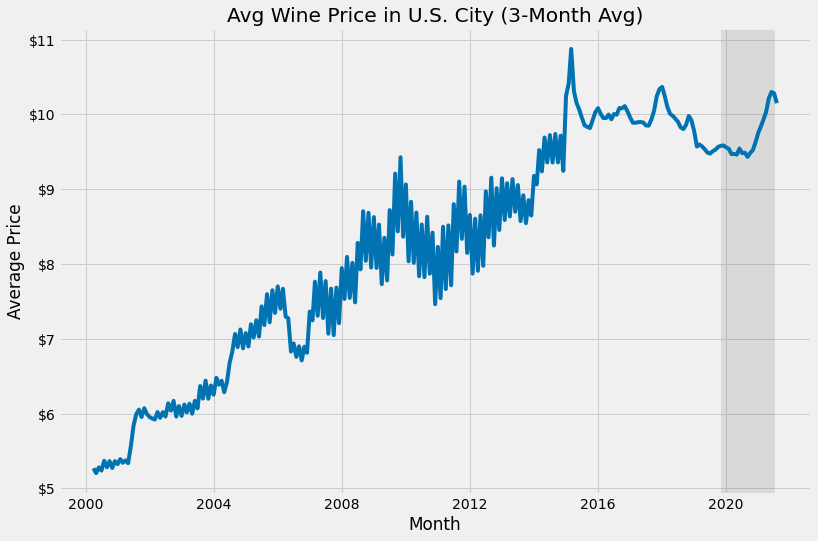

In [32]:
price_line_plot = sns.lineplot(data=train_df['price'].rolling(3).mean())
price_line_plot.set(title='Avg Wine Price in U.S. City (3-Month Avg)', ylabel='Average Price', xlabel='Month')
# shade in the timespan of the additional tariff
price_line_plot.axvspan(
    xmin=train_df['tariff'].where(train_df['tariff']).first_valid_index(), 
    xmax=train_df['tariff'].where(train_df['tariff']).last_valid_index(), 
    color='gray', 
    alpha=0.2
)
price_line_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:.0f}'.format(y)))
plt.gcf().set_size_inches(12, 8)
plt.savefig('../figures/avg-wine-price-in-us-city.png')
plt.show()

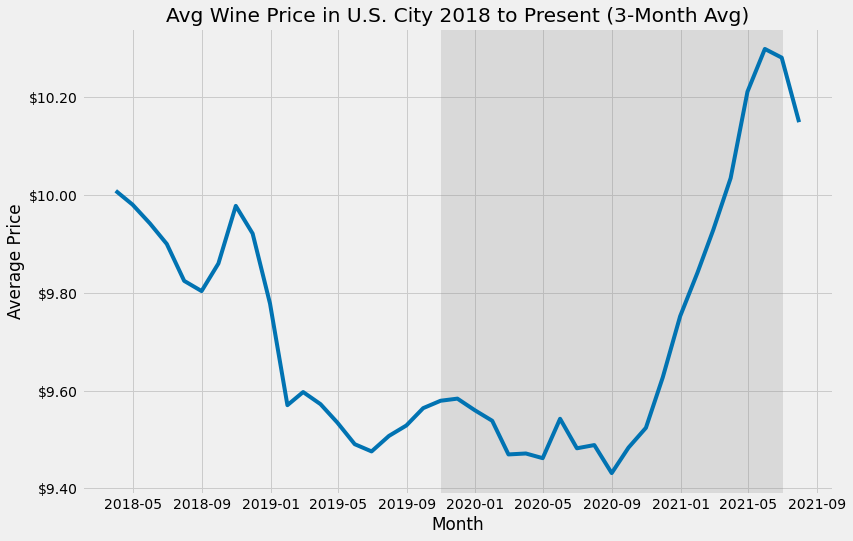

In [33]:
price_line_2018_plot = sns.lineplot(data=train_df.loc['2018-01-01':'2021-12-31']['price'].rolling(3).mean())
price_line_2018_plot.set(title='Avg Wine Price in U.S. City 2018 to Present (3-Month Avg)', ylabel='Average Price', xlabel='Month')
# shade in the timespan of the additional tariff
price_line_2018_plot.axvspan(
    xmin=train_df['tariff'].where(train_df['tariff']).first_valid_index(), 
    xmax=train_df['tariff'].where(train_df['tariff']).last_valid_index(), 
    color='gray', 
    alpha=0.2
)
price_line_2018_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:.2f}'.format(y)))
plt.gcf().set_size_inches(12, 8)
plt.savefig('../figures/avg-wine-price-in-us-city-2018.png')
plt.show()

Alright, let's run the augmented Dickey-Fuller test.

In [34]:
stationarity_tests(train_df['price'])

Augmented Dickey-Fuller Test:
t-stat:                   -1.752900
p-value:                   0.404083
lags:                      9.000000
observations:            249.000000
critical value (1%):      -3.456888
critical value (5%):      -2.873219
critical value (10%):     -2.572994
dtype: float64


     Phillips-Perron Test (Z-tau)    
Test Statistic                 -9.462
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Since the test statistic is greater than the critical value (at the 5% level), we fail to reject the null hypothesis; the series doesn't have a unit root and is therefore non-stationary.

So I do need to make some adjustments to the series to make it stationary.

First, let's decompose the series via seasonal and trend decomposition using LOESS. 

The decomposition plots don't look as good with the style I'm using so I'm going to reset it to the default for this.

In [35]:
style.use('default')

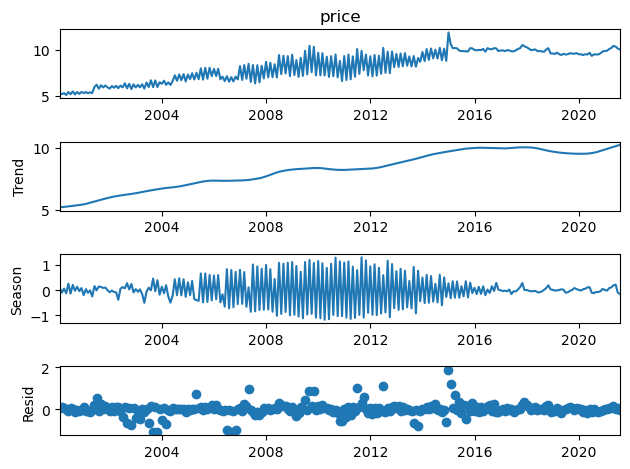

In [36]:
price_dc = STL(train_df['price'].dropna(), seasonal_deg=1, trend_deg=1, robust=True).fit()
price_dc.plot()
plt.show()

<AxesSubplot:xlabel='month'>

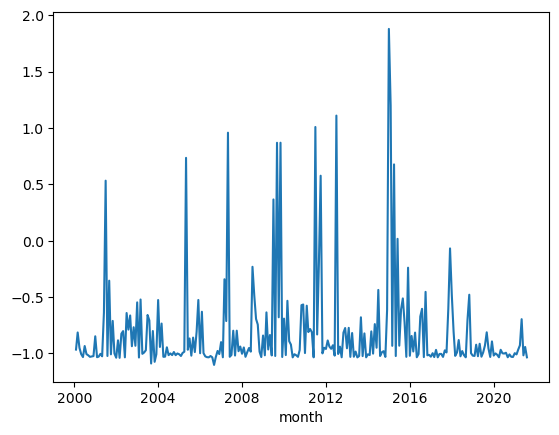

In [37]:
price_s = price_dc.observed - price_dc.seasonal - price_dc.trend - price_dc.weights

sns.lineplot(data=price_s)

In [38]:
stationarity_tests(price_s)

Augmented Dickey-Fuller Test:
t-stat:                 -8.041693e+00
p-value:                 1.839725e-12
lags:                    1.000000e+00
observations:            2.570000e+02
critical value (1%):    -3.456054e+00
critical value (5%):    -2.872853e+00
critical value (10%):   -2.572799e+00
dtype: float64


     Phillips-Perron Test (Z-tau)    
Test Statistic                -14.877
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Now that price is decomposed, I'm going to store off the decomposition and the seasonally-adjusted values as `price_dc` and `price_s`, respectively.

In [39]:
train_df['price_seas'] = price_dc.seasonal
train_df['price_trend'] = price_dc.trend
train_df['price_weights'] = price_dc.weights
train_df['price_s'] = price_s

In [40]:
train_df.head()

price        pop          bott   bott_pc  disp_inc     exp_q  \
month                                                                         
2000-01-31  5.299029  281083000  1.244070e+08  0.442599    9309.1  22385348   
2000-02-29  5.198813  281299000  1.375283e+08  0.488904    9345.2  20954045   
2000-03-31  5.311650  281531000  1.603837e+08  0.569684    9370.3  20240059   
2000-04-30  5.104950  281763000  1.423004e+08  0.505036    9418.3  21745478   
2000-05-31  5.426889  281996000  1.612658e+08  0.571873    9457.3  22059299   

                 exp_val  tariff  duty_val_world   q_world  ...    q_row  \
month                                                       ...            
2000-01-31  4.419970e+07   False    1.298947e+08  30869692  ...  2402418   
2000-02-29  4.088633e+07   False    1.389756e+08  27334547  ...  2118152   
2000-03-31  4.023967e+07   False    1.635349e+08  33950034  ...  2900608   
2000-04-30  4.100174e+07   False    1.727178e+08  37381318  ...  2577645   
2000-05-31  4.187646e+07   False    1.744802e+08  38726698  ...  2554428   

                  cif_row       duty_row  prop_row  cif_r_row  duty_r_row  \
month                                                                       
2000-01-31  550866.019417  162756.310680  0.084392   0.229296    0.067747   
2000-02-29  504564.787339  163492.581602  0.083999   0.238210    0.077186   
2000-03-31  710128.155340  191233.009709  0.093419   0.244820    0.065929   
2000-04-30  598792.079208  177575.247525  0.074062   0.232302    0.068890   
2000-05-31  626929.342493  193309.126595  0.070618   0.245428    0.075676   

            price_seas  price_trend  price_weights   price_s  
month                                                         
2000-01-31    0.090855     5.179916       0.994087 -0.965829  
2000-02-29   -0.106608     5.198646       0.920982 -0.814206  
2000-03-31    0.055213     5.218018       0.989344 -0.950924  
2000-04-30   -0.126735     5.238039       0.999719 -1.006072  
2000-05-31    0.254558     5.258682       0.945813 -1.032163  

[5 rows x 58 columns]

### Disposable Income

In [41]:
stationarity_tests(train_df['disp_inc'])

Augmented Dickey-Fuller Test:
t-stat:                    2.412074
p-value:                   0.999016
lags:                     14.000000
observations:            244.000000
critical value (1%):      -3.457438
critical value (5%):      -2.873459
critical value (10%):     -2.573122
dtype: float64


     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.552
P-value                         0.881
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


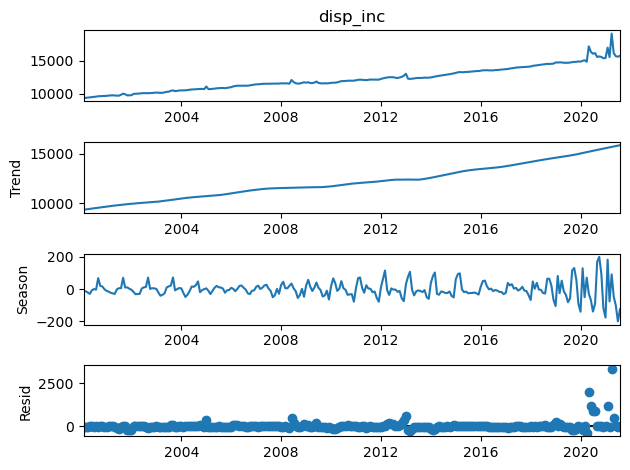

In [42]:
disp_inc_dc = STL(train_df['disp_inc'].dropna(), seasonal_deg=1, trend_deg=1, robust=True).fit()
disp_inc_dc.plot()
plt.show()

<AxesSubplot:xlabel='month'>

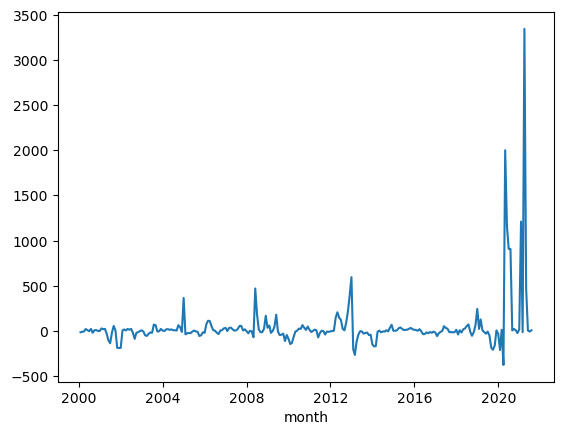

In [43]:
disp_inc_s = disp_inc_dc.observed - disp_inc_dc.seasonal - disp_inc_dc.trend - disp_inc_dc.weights

sns.lineplot(data=disp_inc_s)

In [44]:
stationarity_tests(disp_inc_s)

Augmented Dickey-Fuller Test:
t-stat:                    0.730099
p-value:                   0.990420
lags:                     14.000000
observations:            244.000000
critical value (1%):      -3.457438
critical value (5%):      -2.873459
critical value (10%):     -2.573122
dtype: float64


     Phillips-Perron Test (Z-tau)    
Test Statistic                -13.602
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [45]:
train_df['disp_inc_s'] = disp_inc_s

### Bottled

In [46]:
stationarity_tests(train_df['bott'])

Augmented Dickey-Fuller Test:
t-stat:                   -0.739563
p-value:                   0.836234
lags:                     14.000000
observations:            244.000000
critical value (1%):      -3.457438
critical value (5%):      -2.873459
critical value (10%):     -2.573122
dtype: float64


     Phillips-Perron Test (Z-tau)    
Test Statistic                 -8.447
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


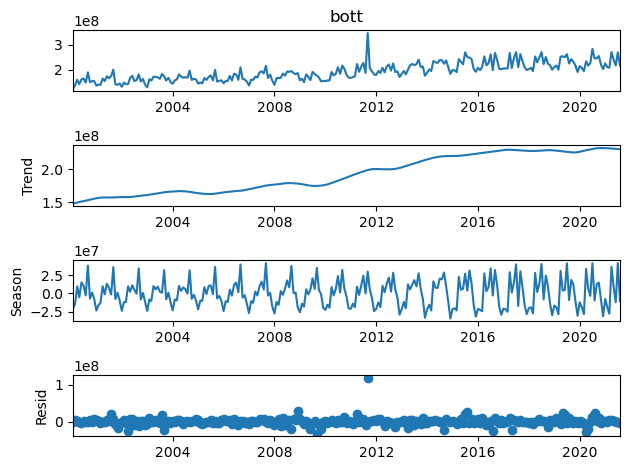

In [47]:
bott_dc = STL(train_df['bott'].dropna(), seasonal_deg=1, trend_deg=1, robust=True).fit()
bott_dc.plot()
plt.show()

<AxesSubplot:xlabel='month'>

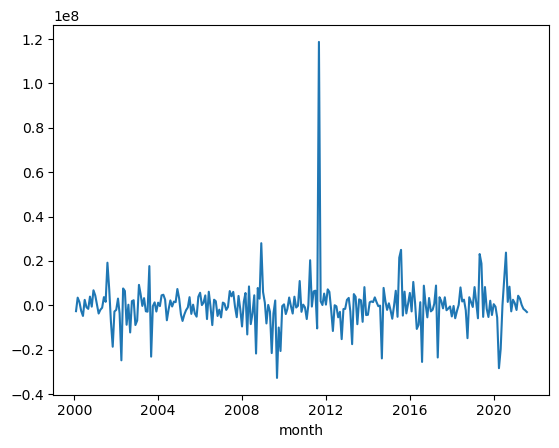

In [48]:
bott_s = bott_dc.observed - bott_dc.seasonal - bott_dc.trend - bott_dc.weights

sns.lineplot(data=bott_s)

In [49]:
stationarity_tests(bott_s)

Augmented Dickey-Fuller Test:
t-stat:                   -5.320494
p-value:                   0.000005
lags:                      9.000000
observations:            249.000000
critical value (1%):      -3.456888
critical value (5%):      -2.873219
critical value (10%):     -2.572994
dtype: float64


     Phillips-Perron Test (Z-tau)    
Test Statistic                -16.117
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [50]:
train_df['bott_seas'] = bott_dc.seasonal
train_df['bott_trend'] = bott_dc.trend
train_df['bott_weights'] = bott_dc.weights
train_df['bott_s'] = bott_s

### Exports Quantity

In [51]:
stationarity_tests(train_df['exp_q'])

Augmented Dickey-Fuller Test:
t-stat:                   -2.235256
p-value:                   0.193699
lags:                     13.000000
observations:            245.000000
critical value (1%):      -3.457326
critical value (5%):      -2.873410
critical value (10%):     -2.573096
dtype: float64


     Phillips-Perron Test (Z-tau)    
Test Statistic                 -9.518
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


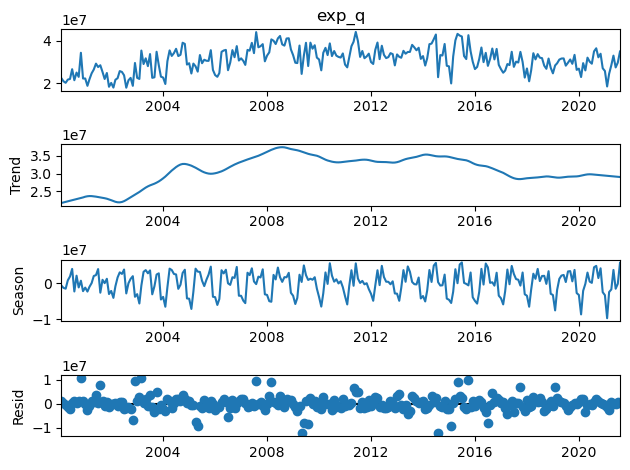

In [52]:
exp_q_dc = STL(train_df['exp_q'].dropna(), seasonal_deg=1, trend_deg=1, robust=True).fit()
exp_q_dc.plot()
plt.show()

<AxesSubplot:xlabel='month'>

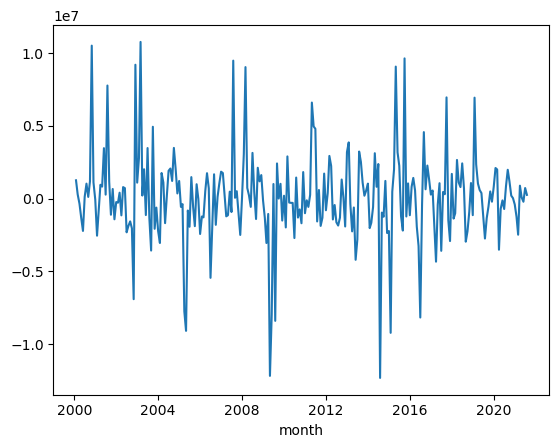

In [53]:
exp_q_s = exp_q_dc.observed - exp_q_dc.seasonal - exp_q_dc.trend - exp_q_dc.weights

sns.lineplot(data=exp_q_s)

In [54]:
stationarity_tests(exp_q_s)

Augmented Dickey-Fuller Test:
t-stat:                 -1.356702e+01
p-value:                 2.252409e-25
lags:                    0.000000e+00
observations:            2.580000e+02
critical value (1%):    -3.455953e+00
critical value (5%):    -2.872809e+00
critical value (10%):   -2.572775e+00
dtype: float64


     Phillips-Perron Test (Z-tau)    
Test Statistic                -13.375
P-value                         0.000
Lags                               16
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [55]:
train_df['exp_q_seas'] = exp_q_dc.seasonal
train_df['exp_q_trend'] = exp_q_dc.trend
train_df['exp_q_weights'] = exp_q_dc.weights
train_df['exp_q_s'] = exp_q_s

## Imports

Since there are another 40 columns or so, I'm going to make a helper function to adjust for seasonality and return a dictionary of items that will let us recompose the observations. After this, I'm going to loop over all of the imports values, check them for stationarity, if they're stationary, I'll return a dictionary containing the stationary values, if they're not stationary, I'll return nothing. If the dictionary is returned, I'll create columns in `train_df` for the adjusted value and the trend, seasonal, and weights components.

In [56]:
def make_stationary(x):
    adf_test = adfuller(x, autolag='AIC')
    if adf_test[0] > adf_test[4].get('1%'):
        dc = STL(x, seasonal_deg=1, trend_deg=1, robust=True).fit()
        adj = dc.observed - dc.trend - dc.seasonal - dc.weights
        
        dc_dict = {
            'adjusted': adj,
            'trend': dc.trend,
            'seasonal': dc.seasonal,
            'weights': dc.weights
        }
    
        return dc_dict
    else:
        return
    

In [57]:
cols_imp_stat = ['duty_val_world', 'q_world', 'cif_world', 'duty_world', 'duty_val_bloc',
       'q_bloc', 'cif_bloc', 'duty_bloc', 'prop_bloc', 'duty_r_bloc',
       'cif_r_bloc', 'duty_val_it', 'q_it', 'cif_it', 'duty_it', 'prop_it',
       'duty_r_it', 'cif_r_it', 'duty_val_au', 'q_au', 'cif_au', 'duty_au',
       'prop_au', 'duty_r_au', 'cif_r_au', 'duty_val_cl', 'q_cl', 'cif_cl',
       'duty_cl', 'prop_cl', 'duty_r_cl', 'cif_r_cl', 'duty_val_row', 'q_row',
       'cif_row', 'duty_row', 'prop_row', 'cif_r_row', 'duty_r_row', 'duty_r_t3', 'q_t3', 'cif_r_t3', 'prop_t3']

In [58]:
for c in cols_imp_stat:
    st = make_stationary(train_df[c])
    if st is None: print(c + ' passed ADF without adjustment')
    nc_s = c + '_s'
    nc_t = c + '_trend'
    nc_se = c + '_seas'
    nc_w = c + '_weights'
    if st is not None:
        train_df[nc_s] = pd.Series(st.get('adjusted'))[0:]
        train_df[nc_t] = pd.Series(st.get('trend'))[0:]
        train_df[nc_se] = pd.Series(st.get('seasonal'))[0:]
        train_df[nc_w] = pd.Series(st.get('weights'))[0:]

duty_world passed ADF without adjustment
duty_bloc passed ADF without adjustment
duty_r_bloc passed ADF without adjustment


<AxesSubplot:xlabel='month', ylabel='duty_r_bloc'>

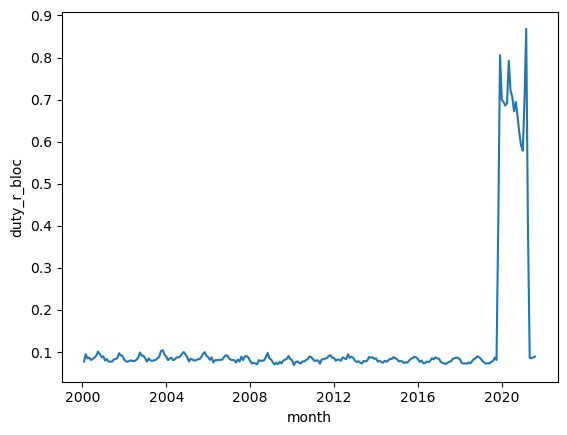

In [59]:
sns.lineplot(data=train_df['duty_r_bloc'].dropna())

I'm skeptical that `duty_r_bloc` is already stationary when the other `duty_r_*` values weren't initially. I think this is due to the tariff being imposed. So I'm going to adjust this for stationarity as well.

In [60]:
duty_r_bloc_dc = STL(train_df['duty_r_bloc'], seasonal_deg=1, trend_deg=1, robust=True).fit()

duty_r_bloc_s = duty_r_bloc_dc.observed - duty_r_bloc_dc.seasonal - duty_r_bloc_dc.trend - duty_r_bloc_dc.weights

train_df['duty_r_bloc_seas'] = duty_r_bloc_dc.seasonal
train_df['duty_r_bloc_trend'] = duty_r_bloc_dc.trend
train_df['duty_r_bloc_weights'] = duty_r_bloc_dc.weights
train_df['duty_r_bloc_s'] = duty_r_bloc_s

In [61]:
train_df

price        pop          bott   bott_pc  disp_inc     exp_q  \
month                                                                          
2000-01-31   5.299029  281083000  1.244070e+08  0.442599    9309.1  22385348   
2000-02-29   5.198813  281299000  1.375283e+08  0.488904    9345.2  20954045   
2000-03-31   5.311650  281531000  1.603837e+08  0.569684    9370.3  20240059   
2000-04-30   5.104950  281763000  1.423004e+08  0.505036    9418.3  21745478   
2000-05-31   5.426889  281996000  1.612658e+08  0.571873    9457.3  22059299   
...               ...        ...           ...       ...       ...       ...   
2021-03-31  10.173180  331061000  2.713890e+08  0.819755   19119.5  28503040   
2021-04-30  10.403817  331126000  2.409610e+08  0.727702   16146.9  33029459   
2021-05-31  10.319847  331204000  2.174436e+08  0.656525   15669.5  27474553   
2021-06-30  10.119847  331297000  2.703948e+08  0.816170   15603.3  29727572   
2021-07-31  10.007790  331395000  2.165504e+08  0.653451   15735.2  34980992   

                 exp_val  tariff  duty_val_world    q_world  ...  \
month                                                        ...   
2000-01-31  4.419970e+07   False    1.298947e+08   30869692  ...   
2000-02-29  4.088633e+07   False    1.389756e+08   27334547  ...   
2000-03-31  4.023967e+07   False    1.635349e+08   33950034  ...   
2000-04-30  4.100174e+07   False    1.727178e+08   37381318  ...   
2000-05-31  4.187646e+07   False    1.744802e+08   38726698  ...   
...                  ...     ...             ...        ...  ...   
2021-03-31  9.578440e+07    True    3.146280e+08  104837000  ...   
2021-04-30  9.818340e+07    True    3.982079e+08  109725863  ...   
2021-05-31  9.907126e+07    True    4.168890e+08  116560687  ...   
2021-06-30  9.771284e+07    True    5.218755e+08  140306764  ...   
2021-07-31  1.102155e+08   False    5.056698e+08  138118834  ...   

            cif_r_t3_seas  cif_r_t3_weights  prop_t3_s  prop_t3_trend  \
month                                                                   
2000-01-31      -0.001508          0.997884  -1.004751       1.470797   
2000-02-29      -0.001999          0.982543  -1.017582       1.489159   
2000-03-31      -0.004827          0.935274  -0.919402       1.507231   
2000-04-30      -0.002130          0.967100  -1.012627       1.525084   
2000-05-31       0.003221          0.967563  -0.748198       1.542783   
...                   ...               ...        ...            ...   
2021-03-31      -0.006295          0.988913  -0.968159       0.906623   
2021-04-30       0.013905          0.990944  -0.975547       0.892374   
2021-05-31       0.011651          0.996506  -1.003593       0.878246   
2021-06-30       0.008194          0.997397  -1.008823       0.864240   
2021-07-31      -0.010307          0.978420  -0.975383       0.850351   

            prop_t3_seas  prop_t3_weights  duty_r_bloc_seas  \
month                                                         
2000-01-31      0.367523         0.929786         -0.005418   
2000-02-29      0.030761         0.964664          0.002133   
2000-03-31     -0.018610         0.968986         -0.007073   
2000-04-30      0.218179         0.996788         -0.004251   
2000-05-31      0.233257         0.856080         -0.008454   
...                  ...              ...               ...   
2021-03-31     -0.106247         0.992486         -0.003191   
2021-04-30     -0.087567         0.995129         -0.005166   
2021-05-31     -0.058364         0.999819         -0.002743   
2021-06-30      0.046916         0.998696         -0.011480   
2021-07-31      0.185364         0.995073          0.000155   

            duty_r_bloc_trend  duty_r_bloc_weights  duty_r_bloc_s  
month                                                              
2000-01-31           0.092341             0.000000      -0.009496  
2000-02-29           0.091743             0.965049      -0.964240  
2000-03-31           0.091152             0.9782

## Johansen Test

In [70]:
johan_test_df = train_df[['price_s', 'bott_s', 'disp_inc_s', 'exp_q_s', 'tariff', 
                          'q_bloc_s', 'cif_r_bloc_s', 'prop_bloc_s', 'duty_r_bloc_s', 
                          'q_it_s', 'cif_r_it_s', 'prop_it_s', 'duty_r_it_s',
                          'q_au_s', 'cif_r_au_s', 'prop_au_s', 'duty_r_au_s',
                          'q_cl_s', 'cif_r_cl_s', 'prop_cl_s', 'duty_r_cl_s',
                          'q_row_s', 'cif_r_row_s', 'prop_row_s', 'duty_r_row_s',
                          'q_t3_s', 'cif_r_t3_s', 'prop_t3_s', 'duty_r_t3_s', 'cif_world_s']].copy()
johan_test_df['tariff'] = johan_test_df['tariff'].astype(int)

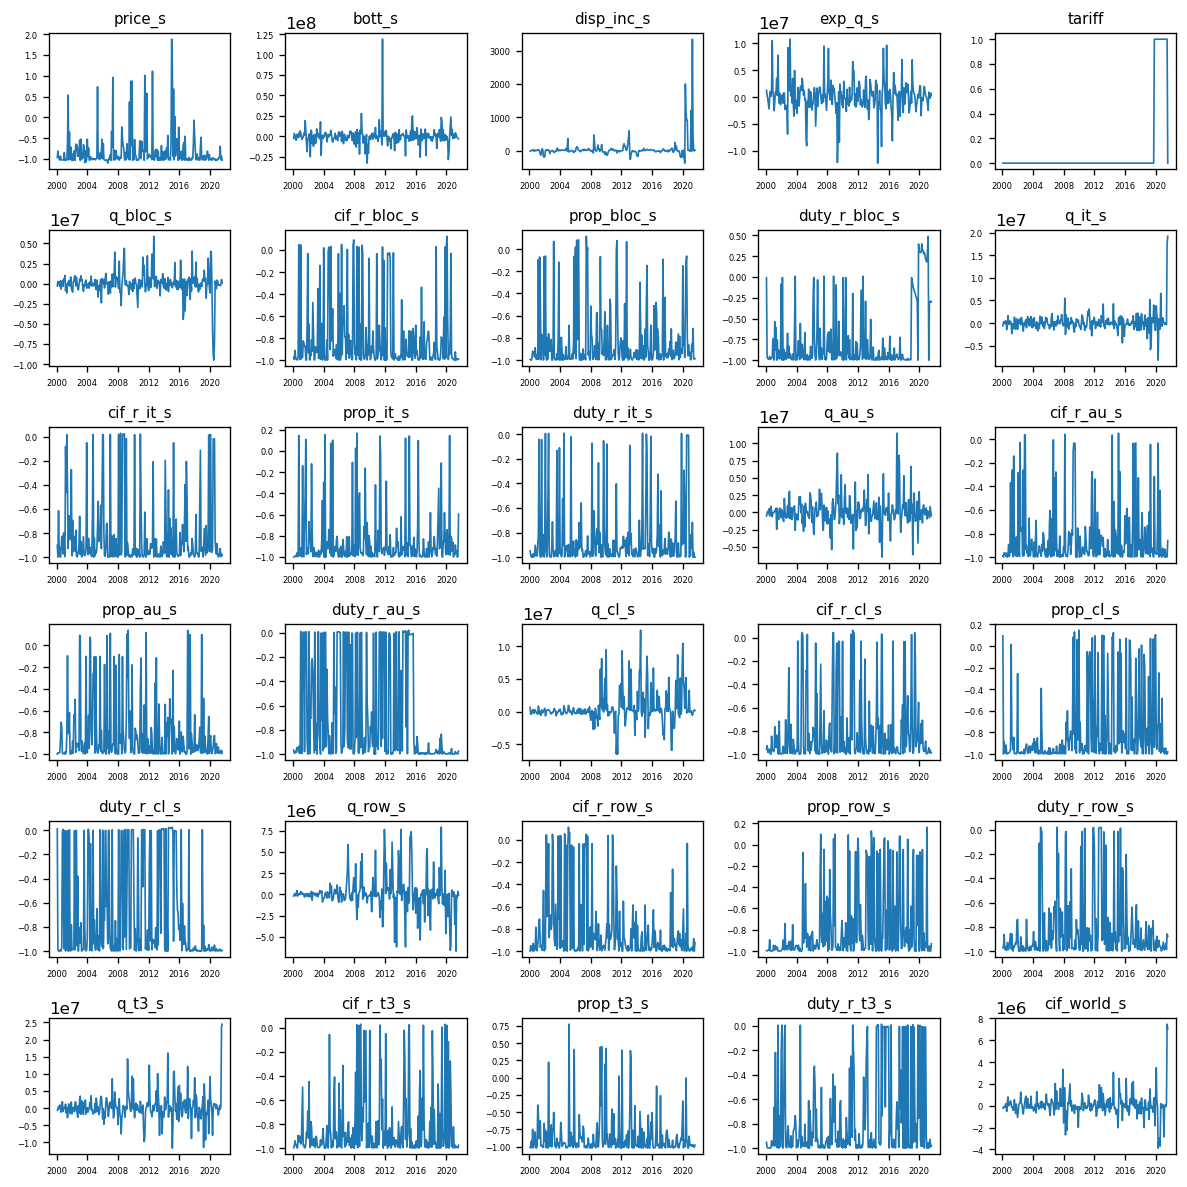

In [71]:
fig, axes = plt.subplots(nrows=6, ncols=5, dpi=120, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    data = johan_test_df[johan_test_df.columns[i]]
    ax.plot(data, linewidth=1)

    ax.set_title(johan_test_df.columns[i], size=9)
    ax.tick_params(labelsize=5)

plt.tight_layout()
plt.show()

Let's define a function that provides a printout of the results of a cointegration johansen test of the variables for our analysis.

In [72]:
def johansen_test(var_df, critical_value=0.05): 
    output = coint_johansen(var_df, -1, 3)
    d = {'0.90': 0, '0.95': 1, '0.99': 2}
    trace_stat = output.lr1
    cvt_values = output.cvt[:, d[str(1-critical_value)]]
    cvm_values = output.cvm[:, d[str(1-critical_value)]]

    print('Cointegration Johansen Test:')
    print('{:<30}'.format('Variable') + '{:<30}'.format('T-Stat > CVs (trace, eig)') + '{:<20}'.format('Significant'))
    print('--'*36)
    for col, trace, cvt, eig in zip(var_df.columns, trace_stat, cvt_values, cvm_values):
        print('{:<30}'.format(col) + '{:<30}'.format('{:<7}'.format(format(trace, '.2f')) + \
            ' > ' + '{:<9}'.format('(' + format(cvt, '.2f') + ', ') + '{:<7}'.format(format(eig, '.2f')  + ')')) + '{:<20}'.format(str(trace > cvt)))

Well, I need to drop some variables because the test works with 12 at the most.

In [73]:
johan_test_df_sm = johan_test_df[['price_s', 
#                                   'bott_s', 
                                  'disp_inc_s',
                                  'exp_q_s', 
                                  'tariff',
                                   'q_bloc_s', 
#                                  'cif_r_bloc_s', 
#                                  'prop_bloc_s', 
                                  'duty_r_bloc_s', 
#                                   'q_it_s', 
#                                   'cif_r_it_s', 
                                #   'prop_it_s', 
                                #   'duty_r_it_s',
#                                   'q_au_s', 
#                                   'cif_r_au_s', 
                                  # 'prop_au_s', 
                                  # 'duty_r_au_s',
#                                   'q_cl_s', 
#                                   'cif_r_cl_s', 
                                  # 'prop_cl_s', 
                                #   'duty_r_cl_s',
                                  'q_row_s', 
#                                   'cif_r_row_s', 
#                                   'prop_row_s', 
                                  'duty_r_row_s',
                                    'q_t3_s',
                                    'duty_r_t3_s',
                                    'cif_world_s'
                                 ]].copy()

In [74]:
johansen_test(johan_test_df_sm)

Cointegration Johansen Test:
Variable                      T-Stat > CVs (trace, eig)     Significant         
------------------------------------------------------------------------
price_s                       684.95  > (263.26, 67.08)     True                
disp_inc_s                    501.17  > (219.41, 61.04)     True                
exp_q_s                       385.22  > (179.52, 54.96)     True                
tariff                        288.60  > (143.67, 48.88)     True                
q_bloc_s                      214.54  > (111.78, 42.77)     True                
duty_r_bloc_s                 161.27  > (83.94,  36.63)     True                
q_row_s                       114.82  > (60.06,  30.44)     True                
duty_r_row_s                  73.43   > (40.17,  24.16)     True                
q_t3_s                        35.52   > (24.28,  17.80)     True                
duty_r_t3_s                   8.27    > (12.32,  11.22)     False               
cif_wor

In [75]:
train_df.to_excel('../data/analysis_data_sa.xlsx')

## Modeling

In [ ]:
# train_mod_df = train_df[['price_s', 'bott_s', 'exp_q_s', 'tariff', 
#                           'q_bloc_s', 'cif_r_bloc_s', 'prop_bloc_s', 'duty_r_bloc_s', 
#                           'q_it_s', 'cif_r_it_s', 'prop_it_s', 'duty_r_it_s',
#                           'q_au_s', 'cif_r_au_s', 'prop_au_s', 'duty_r_au_s',
#                           'q_cl_s', 'cif_r_cl_s', 'prop_cl_s', 'duty_r_cl_s',
#                           'q_row_s', 'cif_r_row_s', 'prop_row_s', 'duty_r_row_s']].copy()

### Lag Order Selection

We'll want to select the lags on the non-stationary data.

In [76]:
endog = ['price', 'bott_s', 'exp_q', 'q_bloc', 'q_t3', 'q_row']
exog = ['disp_inc', 'duty_r_bloc', 'tariff', 'duty_r_t3', 'duty_r_row', 'cif_world']
train_df['tariff'] = train_df['tariff'].astype(int)

model = VAR(endog=train_df[endog], exog=train_df[exog])

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [77]:
lag_orders = model.select_order(maxlags=16)
lag_orders.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [78]:
# train_mod_df.info()

In [79]:
# test_df_2 = train_mod_df.drop(columns=['tariff', 'cif_r_it_s', 'cif_r_bloc_s', 'cif_r_au_s', 'cif_r_cl_s', 'cif_r_it_s', 'cif_r_row_s', 'duty_r_it_s', 'duty_r_au_s', 'duty_r_cl_s', 'duty_r_row_s'])
# test_df_2.columns

In [80]:
# model = VAR(endog=train_mod_df.drop(columns=['tariff', 'cif_r_it_s', 'cif_r_bloc_s', 'cif_r_au_s', 'cif_r_cl_s', 'cif_r_it_s', 'cif_r_row_s', 'duty_r_it_s', 'duty_r_au_s', 'duty_r_cl_s', 'duty_r_row_s'])
#             , exog=train_mod_df[['cif_r_it_s', 'cif_r_bloc_s', 'cif_r_au_s', 'cif_r_cl_s', 'cif_r_it_s', 'cif_r_row_s', 'duty_r_it_s', 'duty_r_au_s', 'duty_r_cl_s', 'duty_r_row_s']])

In [81]:
# lag_orders = model.select_order(maxlags=16)
# lag_orders.summary()

Let's use 2 lags since it seems to have the most votes via the selection criteria.

### Fit the model

In [82]:
endog = ['price_s', 'bott_s', 'exp_q_s', 'q_bloc_s', 'q_t3_s', 'q_row_s']
exog = ['disp_inc_s', 'duty_r_bloc_s', 'tariff', 'duty_r_t3_s', 'duty_r_row_s', 'cif_world_s']
train_df['tariff'] = train_df['tariff'].astype(int)

model = VAR(endog=train_df[endog], exog=train_df[exog])

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [83]:
tsmf = model.fit(2)
tsmf.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 11, Apr, 2022
Time:                     23:15:07
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    149.061
Nobs:                     257.000    HQIC:                   148.120
Log likelihood:          -21026.1    FPE:                1.13089e+64
AIC:                      147.487    Det(Omega_mle):     7.37162e+63
--------------------------------------------------------------------
Results for equation price_s
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.527528         0.136682           -3.860           0.000
disp_inc_s           -0.000053         0.000105           -0.503           0.615
duty_r_bloc_s        -0.103039         0.092293           

In [84]:
stable = tsmf.is_stable(verbose=True)

Eigenvalues of VAR(1) rep
0.5244080121343512
0.5244080121343512
0.5078307485627672
0.4408584344420579
0.4408584344420579
0.4274380760752857
0.4274380760752857
0.3681470920467939
0.22403732661714157
0.20279836395470222
0.20279836395470222
0.13642619058257688


In [85]:
dw_output = durbin_watson(tsmf.resid)
mod_columns = ['price_s', 'bott_s', 'exp_q_s', 'q_bloc_s', 'q_t3_s', 'q_row_s', 'disp_inc_s', 'duty_r_bloc_s', 'tariff', 'duty_r_t3_s', 'duty_r_row_s', 'cif_world_s']

for col, val in zip(mod_columns, dw_output):
    print('{:<62}'.format(str(col), ':'), round(val, 3))

price_s                                                        1.994
bott_s                                                         2.042
exp_q_s                                                        2.031
q_bloc_s                                                       1.828
q_t3_s                                                         2.032
q_row_s                                                        1.973


In [86]:
style.use('fivethirtyeight')

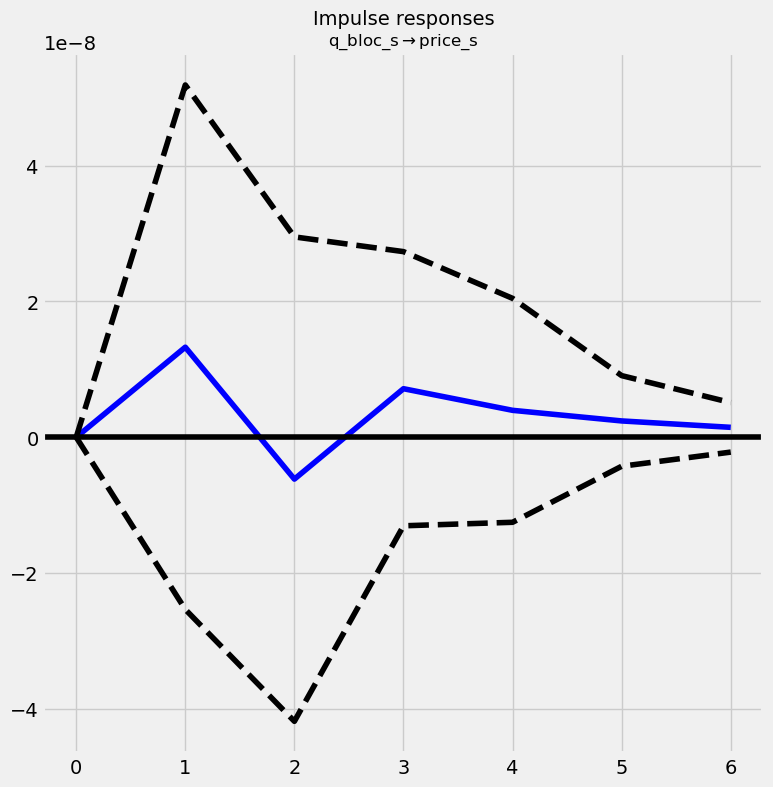

In [87]:
impulse_response = tsmf.irf(6)
ir_plt = impulse_response.plot(impulse='q_bloc_s', response='price_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_duty_r_bloc_on_price.png')
plt.show()

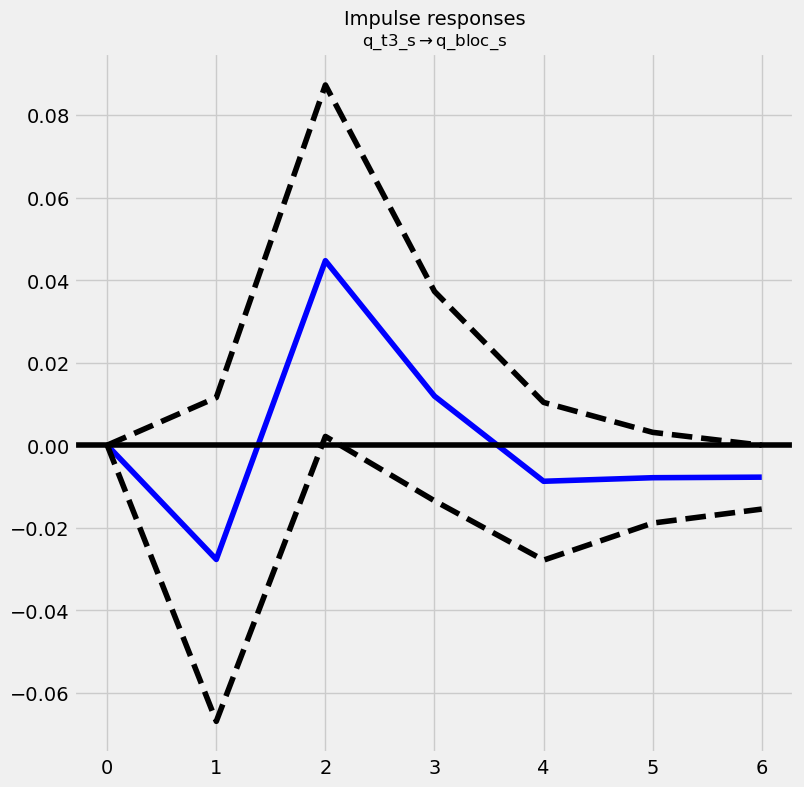

In [88]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='q_t3_s', response='q_bloc_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse--response_duty_r_bloc_on_q_bloc.png')
plt.show()

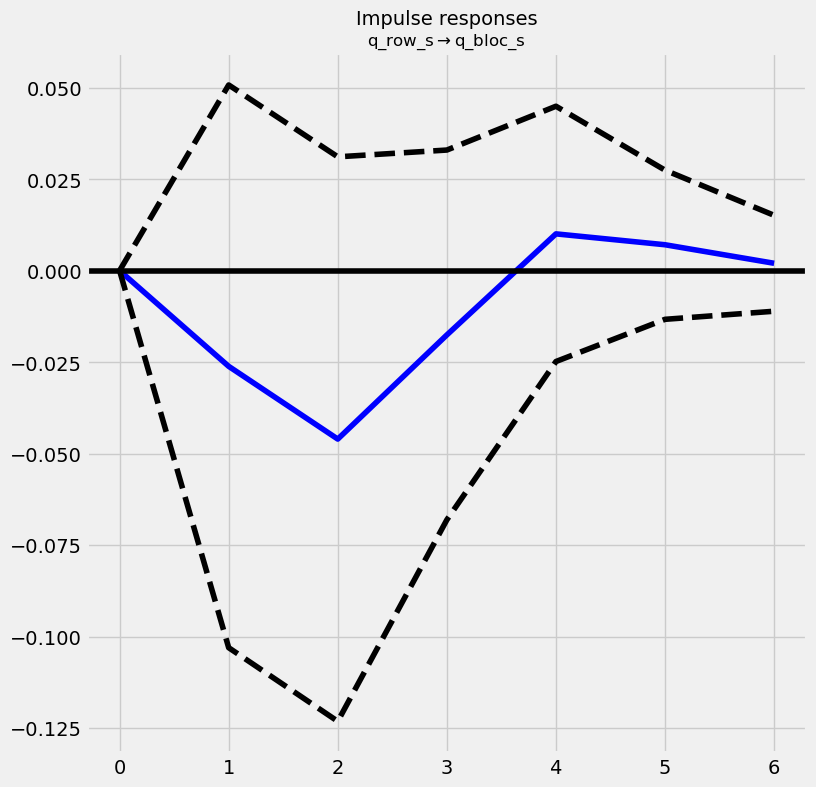

In [89]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='q_row_s', response='q_bloc_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_tariff_rate.png')
plt.show()

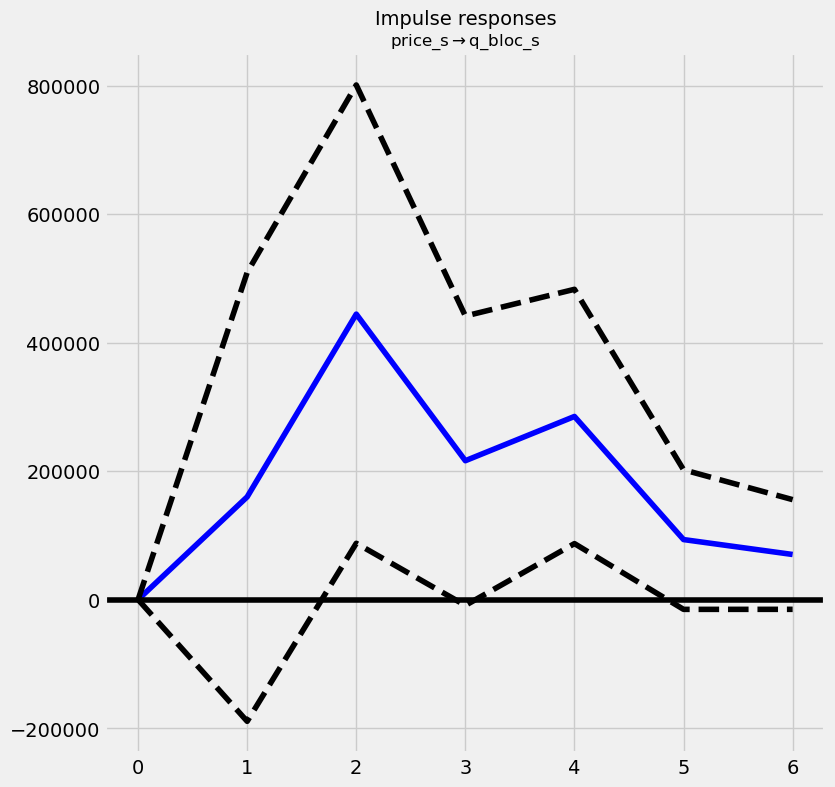

In [90]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='price_s', response='q_bloc_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_tariff_rate.png')
plt.show()

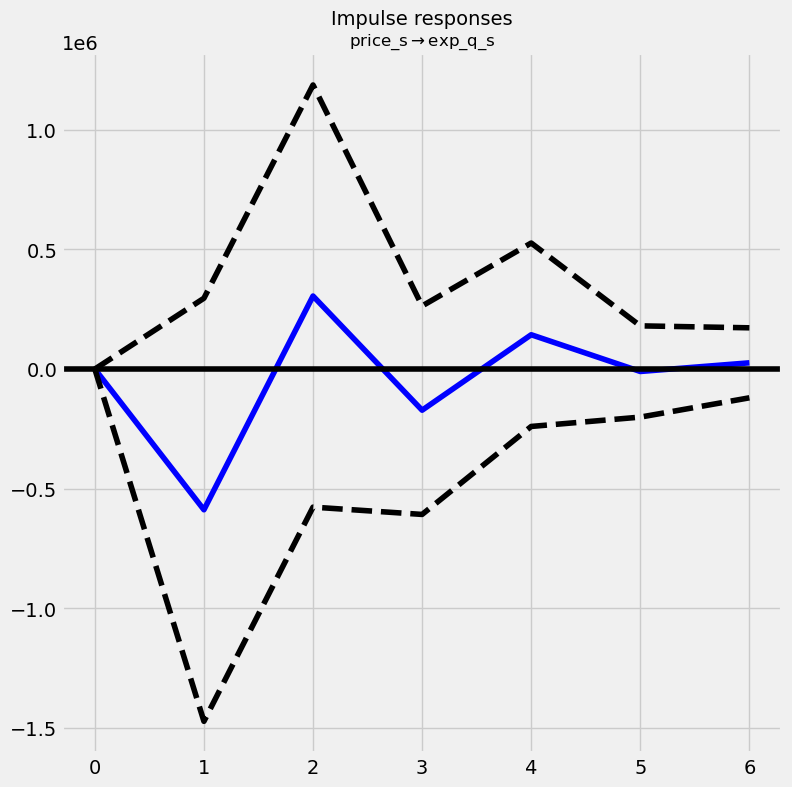

In [91]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='price_s', response='exp_q_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_tariff_rate.png')
plt.show()

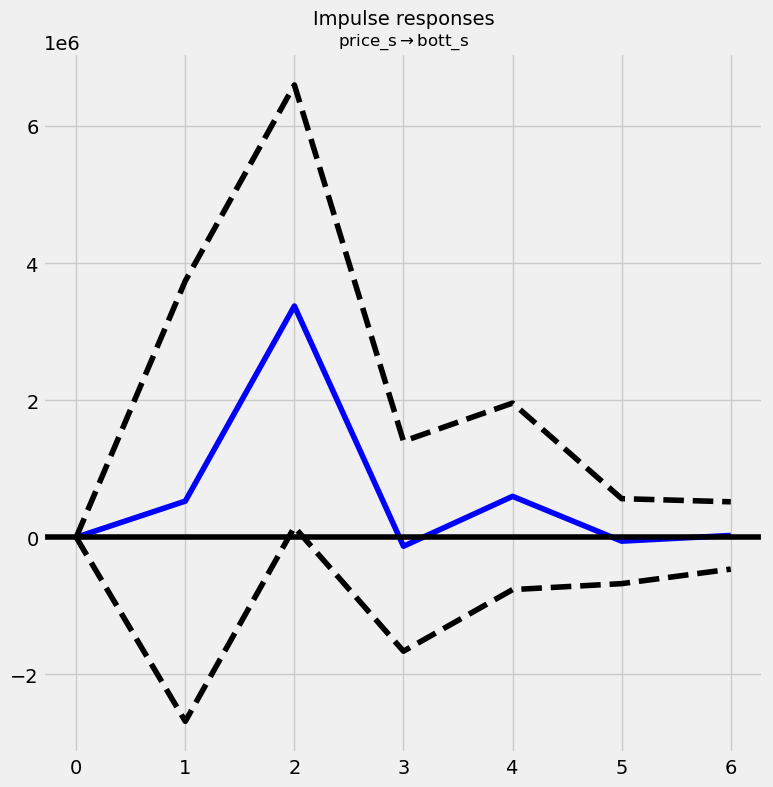

In [92]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='price_s', response='bott_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_tariff_rate.png')
plt.show()

Let's turn `duty_r_bloc` into an endogenous variable and see if we can get some sort of impulse response for it.

In [93]:
endog = ['price', 'duty_r_bloc', 'bott_s', 'exp_q', 'q_bloc', 'q_t3', 'q_row']
exog = ['disp_inc', 'tariff', 'duty_r_t3', 'duty_r_row', 'cif_world']
train_df['tariff'] = train_df['tariff'].astype(int)

model = VAR(endog=train_df[endog], exog=train_df[exog])

lag_orders = model.select_order(maxlags=16)
lag_orders.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.table.SimpleTable'>

In [94]:
endog = ['price_s', 'duty_r_bloc_s', 'bott_s', 'exp_q_s', 'q_bloc_s', 'q_t3_s', 'q_row_s']
exog = ['disp_inc_s', 'tariff', 'duty_r_t3_s', 'duty_r_row_s', 'cif_world_s']
train_df['tariff'] = train_df['tariff'].astype(int)

model = VAR(endog=train_df[endog], exog=train_df[exog])

tsmf = model.fit(2)
tsmf.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 11, Apr, 2022
Time:                     23:15:11
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    146.944
Nobs:                     257.000    HQIC:                   145.788
Log likelihood:          -21046.5    FPE:                9.51092e+62
AIC:                      145.011    Det(Omega_mle):     5.62854e+62
--------------------------------------------------------------------
Results for equation price_s
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.482621         0.152347           -3.168           0.002
disp_inc_s              -0.000032         0.000105           -0.305           0.760
tariff                  -0.089315         0.15

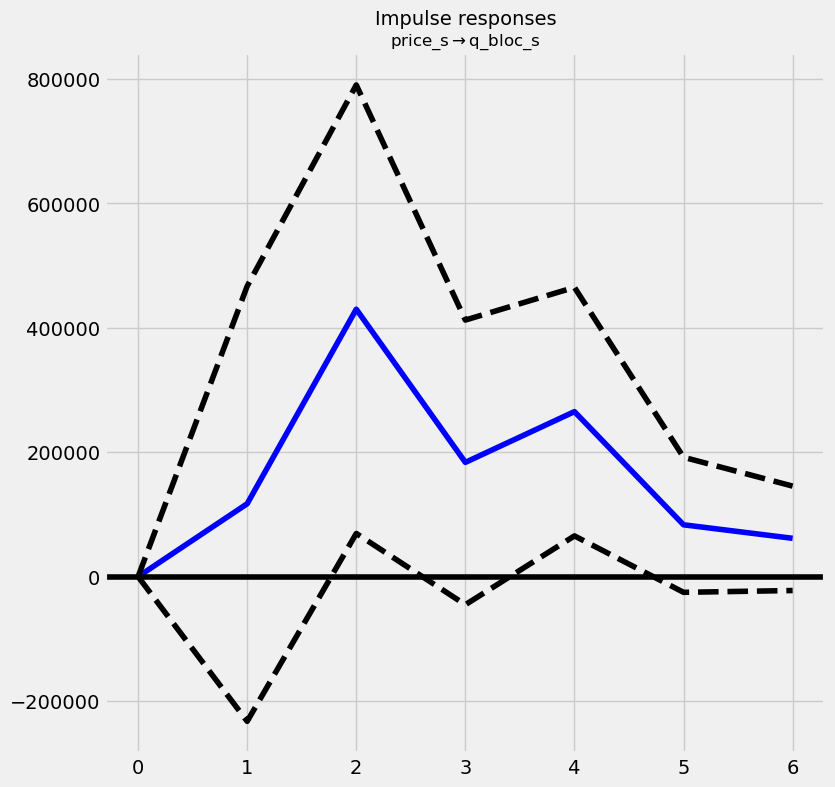

In [95]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='price_s', response='q_bloc_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_tariff_rate.png')
plt.show()

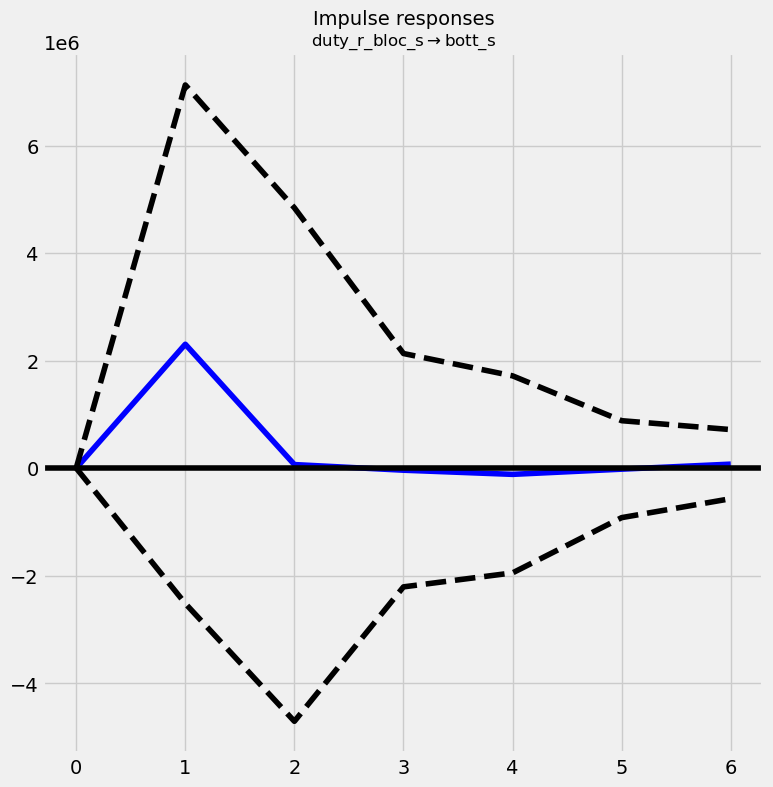

In [96]:
impulse_response = tsmf.irf(6)
impulse_response.plot(impulse='duty_r_bloc_s', response='bott_s')
plt.gcf().set_size_inches(8, 8)
plt.savefig('../figures/impulse-response_duty_r_bloc_on_bottled.png')
plt.show()

Let's create a VARX model

In [98]:
def separate_endog_and_exog(df, endog, exog):
        endog_data = df[endog]
        exog_data = df[exog]

        # convert dfs to matrices
        x = exog_data.to_numpy()
        y = endog_data.to_numpy()

        return y, x

In [99]:
def psi_weights(phi, lag):
        k = phi.shape[0]
        m = phi.shape[1]
        p = np.floor(m/k)
        si = np.zeros((k, k))
        np.fill_diagonal(si, 1)
        if (p < 1):
            p = 1
        if (lag < 1):
            lag = 1
        
        for i in range(1, (lag+1)):
            if (i < (p+1)):
                id_x = (i-1) * k
                t_p = phi[:, id_x:(id_x+k)]
            else:
                t_p = np.zeros((k, k))
            jj = i-1
            jp = np.minimum(jj, p).astype(int)
            if (jp > 0):
                for j in range(1, (jp+1)):
                    jd_x = (j-1) * k
                    id_x = (i-j) * k
                    w1 = phi[:, jd_x:(jd_x+k)]
                    w2 = si[:, id_x:(id_x+k)]
                    t_p = t_p + np.dot(w1, w2)
            si = np.concatenate((si, t_p), axis=1)
        
        return si

In [114]:
def plot_irf(wk, acuwk, lag, orthog=True, cumulative=True):
    td_x = np.array(range(lag+1))

    if (~cumulative):
        plt_data = wk
        plt_title = 'Cumulative Impulse Responses'
    else:
        plt_data = acuwk
        plt_title = 'Impulse Responses'

    # plot impulse responses
    plt.figure(figsize=(10,250))
    for i in range(plt_data.shape[0]):
        plt.subplot((plt_data.shape[0]+1), 1, (i+1))
        x_data = plt_data[i]
        plt.plot(td_x, x_data, 'o-')
        plt.ylabel(str(i))
        
    plt.xlabel('Periods')
    if (orthog):
        plt_title = 'Orthogonal ' + plt_title
    plt.title(plt_title)
    plt.show()

In [101]:
def fit(df, endog, exog, lag, x_lag, include_mean=True, fixed=np.NaN):
        y, x = separate_endog_and_exog(df, endog, exog)
        p = lag
        m = x_lag

        # calculate dimensions for exogenous variables
        if x.shape[1] < 1:
            m = -1
            k_x = 0
        else:
            k_x = x.shape[1]
        # validate lags are non-negative
        if p < 0:
            p = 0

        ist = np.max([p, m])
        nt = y.shape[0]
        k = y.shape[1]
        y_t = y[ist:nt, ]

        xmtx = np.NaN

        if include_mean:
            xmtx = np.ones(nt-ist)
            xmtx = xmtx.reshape((xmtx.shape[0], 1))

        # let's define the columns so that we can keep track of which values are for which columns
        cols = endog
        cols_exog = exog
        
        # add in the lags for endog variables
        if p > 0:
            for i in range(p):
                xmtx = np.concatenate((xmtx, y[(ist-i-1):(nt-i-1),]), axis=1)
                if i > 0:
                    new_cols = [c + '_l' + str(i) for c in endog]
                    # update list of column names
                    cols = np.concatenate([new_cols, cols])
        # add in the lags for exog variables
        if m > -1:
            for i in range(m+1):
                xmtx = np.concatenate((xmtx, x[(ist-i):(nt-i),]), axis=1)
                # update exog column names
                if i > 0:
                    new_cols_exog = [c + '_l' + str(i) for c in exog]
                    cols_exog = np.concatenate([new_cols_exog, cols_exog])

        # update entire set of columns
        cols = np.concatenate([cols, cols_exog])
        cols = np.concatenate([['intercept'], cols])

        p_1 = xmtx.shape[1]
        nobe = xmtx.shape[0]

        beta = np.zeros((p_1, k))
        se_beta = np.ones((p_1, k))
        resi = y_t
        n_par = 0

        if (np.isnan(fixed)):
            xpx = np.dot(xmtx.T, xmtx)
            xpx = xpx.astype(float)
            xpy = np.dot(xmtx.T, y_t)
            xpxi = np.linalg.inv(xpx)
            beta = np.dot(xpxi, xpy)
            resi = y_t - np.dot(xmtx, beta)
            sig = np.matmul(resi.T, resi) / nobe
            co = np.kron(sig, xpxi)
            co_diag = np.diag(co)
            se = co_diag**(1/2)
            se_beta = se.reshape((beta.shape[0], k), order='F')
            n_par = beta.shape[0] * k
            sig = sig.astype(float)
            sig_det = np.linalg.det(sig)
            d_1 = np.log(sig_det)
            aic = d_1 + 2 * n_par / nobe
            bic = d_1 + np.log(nobe) * n_par / nobe
        else:
            beta = np.zeros((p_1, k))
            se_beta = np.ones((p_1, k))
            resi = y_t
            n_par = 0
            for i in range(k):
                id_x = np.argwhere(np.any(fixed[:, i] == 1))
                n_par = n_par + len(id_x)
                if (len(id_x) > 0):
                    x_m = xmtx[:, id_x]
                    y_1 = y_t[:, i].reshape((nobe, 1))
                    xpx = np.dot(x_m.T, x_m)
                    xpy = np.dot(x_m.T, y_1)
                    xpx = xpx.astype(float)
                    xpxi = np.linalg.inv(xpx)
                    beta_1 = np.dot(xpxi, xpy)
                    res = y_1 - np.dot(x_m, beta_1)
                    sig_1 = np.sum(res**2) / nobe
                    sig_1 = sig_1.astype(float)
                    diag_sig_1 = np.diag(xpxi) * sig_1
                    se = diag_sig_1**(1/2)
                    beta[id_x, i] = beta_1
                    se_beta[id_x, i] = se
                    resi[:, i] = res
            sig = np.matmul(resi.T, resi) / nobe
            sig = sig.astype(float)
            d_1 = np.log(np.linalg.det(sig))
            aic = d_1 + 2 * n_par / nobe
            bic = d_1 + np.log(nobe) * n_par / nobe
        
        ph0 = np.NaN
        icnt = 0

        if (include_mean):
            ph0 = beta[0,:]
            icnt = icnt + 1
            print('Constant Term:')
            print('est:', [np.round(i, 4) for i in ph0])
            print('se:', [np.round(i, 4) for i in se_beta[0,:]])
        
        phi = np.NaN

        if (p > 0):
            phi = beta[(icnt):(icnt+k*p),].T
            se_phi = se_beta[(icnt):(icnt+k*p),].T
            for i in range(1, p+1):
                print('AR(' + str(i) + ') matrix:')
                jcnt = (i-1) * k
                print('\n'.join([' '.join(['{:.3f}'.format(item) for item in row]) for row in phi[:,jcnt:(jcnt+k)]]))
                print('standard errors:')
                print('\n'.join([' '.join(['{:.3f}'.format(item) for item in row]) for row in se_phi[:,jcnt:(jcnt+k)]]))
            icnt = icnt + k * p

        if (m > -1):
            print('coefficients of exogenous variables:')
            beta_exog = beta[icnt:icnt+(m+1)*k_x,:].T
            se_beta_exog = se_beta[icnt:icnt+(m+1)*k_x,:].T
            if (k_x == 1):
                beta_exog = beta_exog.T
                se_beta_exog = se_beta_exog.T
            for i in range(m):
                jdx = i * k_x
                print('l' + str(i), 'coefficient matrix')
                print('\n'.join([' '.join(['{:.3f}'.format(item) for item in row]) for row in beta_exog[:,jdx:(jdx+k_x)]]))
                print('standard errors:')
                print('\n'.join([' '.join(['{:.3f}'.format(item) for item in row]) for row in se_beta_exog[:,jdx:(jdx+k_x)]]))

        print('Residual Covariance Matrix:')
        print('\n'.join([' '.join(['{:.5f}'.format(item) for item in row]) for row in sig]))
        print('Information Criteria:')
        print('AIC:', '{:.3f}'.format(aic))
        print('BIC:', '{:.3f}'.format(bic))

        return y, x, beta, se_beta, resi, sig, beta_exog, ph0, phi, cols, cols_exog

In [102]:
def transform(y, x, lag, x_lag, beta, ph0, phi, sig, step, new_x=np.NaN, origin=0):

    n_t = y.shape[0]
    k = y.shape[1]
    dim_x = x.shape[1]
    se = np.NaN
    ph0 = ph0.reshape((3, 1))

    if (len(ph0) < 1):
        ph0 = np.zeros(k, 1)
    if (step < 1):
        step = 1
    if (origin < 1):
        origin = n_t
    
    if (~np.isnan(new_x)):
        # estimate values
        step = np.min([new_x.shape[0], step])
        y_new = y[0:origin]
        if (dim_x > 1):
            x = np.concatenate((x[0:origin], new_x), axis=0)

        for i in range(step):
            t_p = ph0
            t_i = origin + i
            for i in range(1, lag):
                id_x = (i-1) * lag
                t_p = t_p + np.dot(phi[:, (id_x+1):(id_x+k)], y_new[t_i-i, :].reshape(dim_x, 1))
            if (x_lag > -1):
                for i in range(x_lag):
                    id_x = i * dim_x
                    t_p = t_p + np.dot(beta[:, (id_x+1):(id_x+dim_x)], x[t_i-i, :].reshape(dim_x, 1))
            y_new = np.concatenate((y_new, t_p), axis=0)

        # standard errors of predictions
        weights = psi_weights(phi, step)
        se = np.diag(sig)**(1/2)
        se = se.reshape(1, k)
        if step > 1:
            for i in range(2, step):
                id_x = (i-1) * k
                wk = weights[:, id_x:(id_x+k)]
                si = si + np.linalg.multi_dot([wk, sig, wk.T])
                se1 = np.diag(si)**(1/2)
                se1 = se1.reshape(1, k)
                se = np.concatenate((se, se1), axis=0)

        print('Prediction at Origin:', origin)
        print('Point forecasts:')
        print('\n'.join([' '.join(['{:.4f}'.format(item) for item in row]) for row in y_new[:, (origin+1):(origin+step)]]))
        print('Standard errors:')
        print('\n'.join([' '.join(['{:.4f}'.format(item) for item in row]) for row in se[0:step,:]]))
    
    return y_new, se

In [103]:
def irf(beta_exog, sig, phi, p, x_lag, cumulative_irf, lag=12, orthog=True):

    m = x_lag
    k = phi.shape[0]
    si = np.diag(np.ones(k))
    wk = si.reshape((1, si.size))
    awk = wk
    acuwk = awk

    if (p < 1):
        p = 1
    if (m < 1):
        m=1

    for i in range(1, (lag+1)):
        if (i < (p+1)):
            id_x = (i-1) * k
            t_p = phi[:, id_x:(id_x+k)]
        else:
            t_p = np.zeros((k, k))
        jj = i-1
        jp = np.minimum(jj, p).astype(int)
        if (jp > 0):
            for j in range(1, (jp+1)):
                jd_x = (j-1) * k
                id_x = (i-j) * k
                w1 = phi[:, jd_x:(jd_x+k)]
                w2 = si[:, id_x:(id_x+k)]
                t_p = t_p + np.dot(w1, w2)
        si = np.concatenate((si, t_p), axis=1)
        wk = np.concatenate((wk, t_p.reshape((1, t_p.size))), axis=1)
        awk = awk + t_p.reshape((1, t_p.size), order='F')
        # print(awk.shape)
        acuwk = np.concatenate((acuwk, awk), axis=0)
        # print(acuwk.shape)
    
    acuwk = acuwk.T
    
    orsi = np.NaN
    wk1 = np.NaN
    awk1 = np.NaN
    acuwk = np.NaN

    if (orthog):
        m1 = np.linalg.cholesky(sig)
        p1 = m1
        if (~np.isnan(wk1)):
            wk1 = np.concatenate((wk1, p1), axis=1)
        else:
            wk1 = p1.reshape((p1.size, 1), order='F')
        awk1 = wk1
        acuwk1 = awk1
        if (~np.isnan(orsi)):
            orsi = np.concatenate((orsi, p1), axis=1)
        else:
            orsi = p1
        for i in range(1, p+1):
            id_x = i*k
            w1 = si[:, id_x:(id_x+k)]
            w2 = np.dot(w1, p1)
            orsi = np.concatenate((orsi, w2), axis=1)
            wk1 = np.concatenate((wk1, w2.reshape((w2.size, 1), order='F')), axis=1)
            awk1 = awk1 + w2.reshape((w2.size, 1), order='F')
            acuwk1 = np.concatenate((acuwk1, awk1), axis=1)
    
    if (orthog):
        plot_irf(wk=wk1, acuwk=acuwk1, lag=p, cumulative=cumulative_irf)
    else:
        plot_irf(wk=wk, acuwk=acuwk, lag=p, orthog=orthog, cumulative=cumulative_irf)

    kx = int(np.floor(beta_exog.shape[1] / (1 + m)))
    psi_x = beta_exog[:, 0:kx]
    wk = psi_x.reshape((1, psi_x.size), order='F')
    awk = wk
    acuwk = awk
    for i in range(1, lag+1):
        if (i < (m+1)):
            id_x = (i-1) * kx
            t_p = beta_exog[:, id_x:(id_x+kx)]
        else:
            t_p = np.zeros((k, kx))
        jj = i-1
        jp = np.minimum(jj, p).astype(int)
        if (jp > 0):
            for j in range(1, (jp+1)):
                jd_x = (j-1) * k
                id_x = (i-j) * k
                w1 = phi[:, jd_x:(jd_x+k)]
                w2 = si[:, id_x:(id_x+kx)]
                t_p = t_p + np.dot(w1, w2)
        psi_x = np.concatenate((psi_x, t_p), axis=1)
        wk = np.concatenate((wk, t_p.reshape((1, t_p.size))), axis=1)
        awk = awk + t_p.reshape((1, t_p.size), order='F')
        acuwk = np.concatenate((acuwk, awk), axis=0)

    if (orthog):
        plot_irf(wk=wk1, acuwk=acuwk1, lag=p, cumulative=cumulative_irf)
    else:
        plot_irf(wk=wk, acuwk=acuwk, lag=p, orthog=orthog, cumulative=cumulative_irf)

    # lastly just return the values for the irfs
    return si, orsi, psi_x

In [105]:
endog = ['price', 'exp_q', 'q_bloc', 'q_t3', 'q_row']
exog = ['disp_inc', 'duty_r_bloc', 'tariff', 'duty_r_t3', 'duty_r_row', 'cif_world']
y, x, beta, se_beta, resi, sig, beta_exog, ph0, phi, cols, cols_exog = fit(train_df, endog, exog, lag=2, x_lag=2, include_mean=True, fixed=np.NaN)

Constant Term:
est: [0.2678, -26481000.4753, -2913784.8698, 12239539.9527, -10740151.754]
se: [0.8281, 10848907.7715, 3962395.2221, 9948562.6085, 5525934.9564]
AR(1) matrix:
-0.044 0.000 -0.000 -0.000 -0.000
-126918.643 0.398 -0.181 -0.108 0.007
-248421.721 -0.013 0.376 -0.069 0.012
350842.740 0.085 -0.381 0.333 0.289
172780.014 0.039 0.034 -0.016 0.551
standard errors:
0.030 0.000 0.000 0.000 0.000
395549.114 0.064 0.172 0.066 0.124
144468.176 0.023 0.063 0.024 0.045
362722.701 0.059 0.158 0.060 0.113
201474.538 0.033 0.088 0.034 0.063
AR(2) matrix:
0.895 0.000 0.000 0.000 0.000
375993.560 0.273 -0.183 0.181 -0.225
-180586.591 -0.000 0.104 0.045 0.016
230312.485 -0.063 0.238 0.248 -0.190
403267.643 -0.085 0.145 0.055 0.175
standard errors:
0.030 0.000 0.000 0.000 0.000
392345.078 0.066 0.168 0.065 0.126
143297.952 0.024 0.062 0.024 0.046
359784.566 0.060 0.154 0.059 0.116
199842.549 0.034 0.086 0.033 0.064
coefficients of exogenous variables:
l0 coefficient matrix
0.000 -0.587 0.147 8

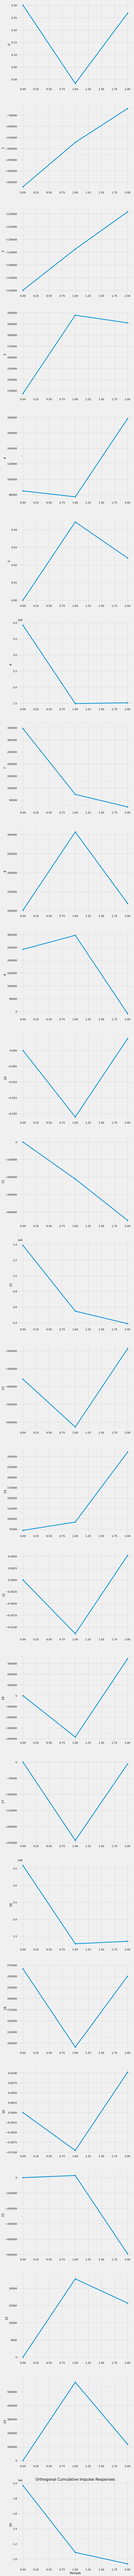

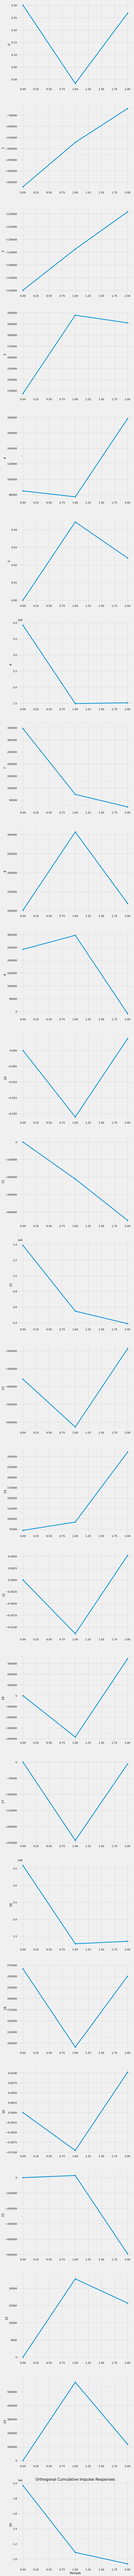

In [115]:
si, orsi, psi_x = irf(beta_exog, sig, phi, p=2, x_lag=2, cumulative_irf=False, lag=12, orthog=True)